In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

from sleep_analysis.data import read_data
from sleep_analysis.analysis import mortality_filter, make_zeitgeber_df, summarize, cumulative_sleep, sleep_filter, bout_filter
from sleep_analysis.plotting import single_trial_zeitgeber_fig, zeitgeber_fig, actogram, per_diem_fig, cumulative_sleep_fig, cumulative_bout_number_fig, cumulative_bout_duration_fig 
from sleep_analysis.utils import get_single_timepoint_glitches, set_light_cycle, get_lights_on_datetimes

import pingouin as pg

Global matplotlib settings

In [2]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}
plt.rcParams.update(params)

# Navigating this notebook

There is an interactive table of contents which can be accessed from the third button down in the left column if you're viewing this with jupyter lab.

# A note about jupyter notebooks

Order of cell execution is very important. There is nothing stopping you from executing cells out of order, but doing so may lead to confusing and irreproducible results. 

There is a button on the top bar that looks like a fast-forward symbol. Hitting that will restart the session and re-run all cells in order. 

**When in doubt hit fast-forward**

## Example of what can go wrong when cells are executed out of order

Instantiate a list with ten elements

In [3]:
foo = list(range(10))
foo

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Select the last element of `foo`

In [4]:
foo[-1]

9

Slice `foo` in place

In [5]:
foo = foo[3:6]
foo

[3, 4, 5]

Try executing the first cell, then third and second and see what happens

# Documentation  

All `sleep_analysis` methods have docstrings. To see usage instructions simply execute `method_name?`, like this

In [6]:
read_data?

Signature: read_data(data_path)
Docstring:
Parses data into DataFrame

Args:
  data_path: path to data file - str

Returns:
  data_df - pd.DataFrame
File:      ~/clandinin/sleep_analysis/sleep_analysis/data.py
Type:      function


To view source, execute `method_name??`

In [7]:
read_data??

Signature: read_data(data_path)
Source:   
def read_data(data_path):
    """ Parses data into DataFrame

    Args:
      data_path: path to data file - str

    Returns:
      data_df - pd.DataFrame
    """
    df = pd.read_csv(
        data_path,
        sep='   ',
        header=None,
        usecols=[1, 2] + list(range(9, 42)),
        parse_dates=[[1, 2]],
        index_col='1_2'
    )
    df.columns = ['light'] + [f'fly_{idx}' for idx in range(32)]
    df.index.name = 'date'
    df = df.astype('int32')

    return df
File:      ~/clandinin/sleep_analysis/sleep_analysis/data.py
Type:      function


# Read and preprocess data

Order of execution strongly matters as the variables `mutant_df` and `control_df` are modified by each step. 

For instance, if you are processing data from a very long trial that few flies survived and are using the heuristic for `mortality_filter`, you would want to slice the dataframes to length before running `mortality_filter`

In [8]:
mutant_path = '/Users/andrew2/clandinin/sleep_analysis/data/m_fs4-tt.txt'
control_path = '/Users/andrew2/clandinin/sleep_analysis/data/m-cs-iso.txt'

In [9]:
mutant_df = read_data(mutant_path)
control_df = read_data(control_path)

/Users/andrew2/.pyenv/versions/3.7.1/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Data is represented as a "data frame" - rows and columns indexed by dates. They can be easily inspected like this:

In [10]:
mutant_df

light  fly_0  fly_1  fly_2  fly_3  fly_4  fly_5  fly_6  fly_7  fly_8  ...  fly_22  fly_23  \
date                                                                                       ...                   
2021-06-30 16:51:00      1      2      1      2      3      3      2      4      1      2  ...       2       1   
2021-06-30 16:52:00      1      0      2      2      3      4      2      4      1      2  ...       2       3   
2021-06-30 16:53:00      1      2      2      0      3      1      2      1      0      0  ...       0       3   
2021-06-30 16:54:00      1      3      1      0      1      1      0      1      1      5  ...       2       3   
2021-06-30 16:55:00      1      2      1      0      1      3      0      2      0      2  ...       0       2   
...                    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...     ...     ...   
2021-07-22 09:03:00      1      0      1      0      0      0      0      0      0      0  ...       1       0   
2021-07-22 09:04:00      1      0      0      0      0      0      0      0      0      0  ...       0       0   
2021-07-22 09:05:00      1      0      0      0      0      0      0      0      0      0  ...       0       0   
2021-07-22 09:06:00      1      0      2      0      0      0      0      0      0      0  ...       1       0   
2021-07-22 09:07:00      1      0      1      0      0      0      0      0      0      0  ...       0       0   

                     fly_24  fly_25  fly_26  fly_27  fly_28  fly_29  fly_30  fly_31  
date                                                                                 
2021-06-30 16:51:00       2       0       2       2       1       2       1       2  
2021-06-30 16:52:00       1       1       3       3       1       3       2       2  
2021-06-30 16:53:00       0       3       2       0       2       2       2       4  
2021-06-30 16:54:00       2       0       2       0       1       0       1       4  
2021-06-30 16:55:00       2       0       1       0       0       0       1       3  
...                     ...     ...     ...     ...     ...     ...     ...     ...  
2021-07-22 09:03:00       0       0       0       0       0       0       2       0  
2021-07-22 09:04:00       0       0       0       0       0       0       0       0  
2021-07-22 09:05:00       0       0       0       0       0       0       0       0  
2021-07-22 09:06:00       0       0       0       0       0       0       0       0  
2021-07-22 09:07:00       0       0       0       0       0       0       0       0  

[31217 rows x 33 columns]

In [11]:
summarize(mutant_df)

General summary:

	 Data ranges from 2021-06-30 16:51:00 to 2021-07-22 09:07:00

	 31217 timepoints

	 32 flies



No missing timepoints



Light cycle:

	 21 well-formed cycles of average length 0 days 23:59:54.285714285

	 0 malformed cycles:

		 0 too short:

		 0 too long:



In [12]:
summarize(control_df)

General summary:

	 Data ranges from 2021-06-30 16:51:00 to 2021-07-22 09:07:00

	 31217 timepoints

	 32 flies



No missing timepoints



Light cycle:

	 21 well-formed cycles of average length 0 days 23:59:54.285714285

	 0 malformed cycles:

		 0 too short:

		 0 too long:



## Mortality filter

With no arguments, `mortality_filter` uses a simple heuristic to infer fly mortality from activity. By default, a fly dormant for the last 12 hours of the dataset is considered to be dead and the column corresponding to that fly is removed from the dataset. 

The heuristic is intended for quick exploration of a dataset. For proper science purposes, fly mortality should be specified manually. `actogram` is probably the easiest way to identify surviving flies. Once they are identified, the mortality filter can be applied like this:

```
surviving_flies = ['fly_0', 'fly_10', 'fly_23']
mutant_df = mortality_filter(mutant_df, surviving_flies=surviving_flies
```

As always, documentation can be viewed with `mortality_filter?`

In [13]:
mutant_df = mortality_filter(mutant_df)

Using mortality heuristic
Pruning {'fly_19', 'fly_9', 'fly_7', 'fly_16', 'fly_5', 'fly_12', 'fly_23', 'fly_2', 'fly_13', 'fly_17', 'fly_25', 'fly_4', 'fly_26', 'fly_27', 'fly_18', 'fly_24'}


In [14]:
control_df = mortality_filter(control_df)

Using mortality heuristic
Pruning {'fly_19', 'fly_16', 'fly_3', 'fly_5', 'fly_12', 'fly_31', 'fly_17', 'fly_28', 'fly_25'}


## Data set level slicing

Subsets of dates can be sliced as follows, which you might want to use if you wanted say, exclude the first day from all subsequent analysis. Note that all plotting methods have arguments for date selection, you don't have to do it here.

Further note that this modifies `mutant_df` and `control_df` in place

Delete/comment out this cell to use the whole dataset

In [15]:
start_time = datetime(2021, 7, 1)
end_time = datetime(2021, 7, 14)
mutant_df = mutant_df.loc[start_time:end_time]
control_df = control_df.loc[start_time:end_time]

## Zeitgeber dataframe

The final step of preprocessing is to construct a dataframe where the light column is used to divide the data into zeitgeber days. Most plots require this format.

By default, `make_zeitgeber_df` discards some data at either end of the dataset to retain only complete zeitgeber days. In this example 7/01 and 7/14 would be discarded (see actogram). This is not always desirable behavior. [Later](#Including-incomplete-days) I'll show you how to include the incomplete days on the ends of the dataset.

### Reliance on the light column

As the light cycle is not precisely 24 hours, it cannot be manually specified but must be inferred from the light column. This has the unfortunate consequence that `make_zeitgeber_df` (and as a result, most plots) is extremely sensitive to glitches in the light column. [Dealing with glitches in the light column](#Dealing-with-glitches-in-the-light-column) explains how to resolve this problem.

In [120]:
mutant_zg_df = make_zeitgeber_df(mutant_df)
control_zg_df = make_zeitgeber_df(control_df)

# Actogram

Activity summary for single flies or averaged across individual flies. Shows all data.

Note that `actogram` requires the raw dataframe, not the zeitgeber df. 


## Faithfulness

By default, `actogram` is faithful to `make_zeitgeber_df` (which it uses under the hood) and not the data. If the light column is well-formed it will be faithful to the data. If not, things will get funky, alerting to you the problem with the light column, which might have otherwise passed unnoticed. In this mode the dates displayed are not strictly accurate, as it slices across zeitgeber days which almost never line up exactly with calendar days.

It is sometimes useful to see a literal representation of the data (such as when trying to inspect data with a malformed light column). This can be accomplished by setting `zg_faithful=False`. This will produce the same output as clocklab. In this mode the dates are accurate (it slices from midnight to midnight).

## Usage

By default, actogram shows activity data averaged across all flies

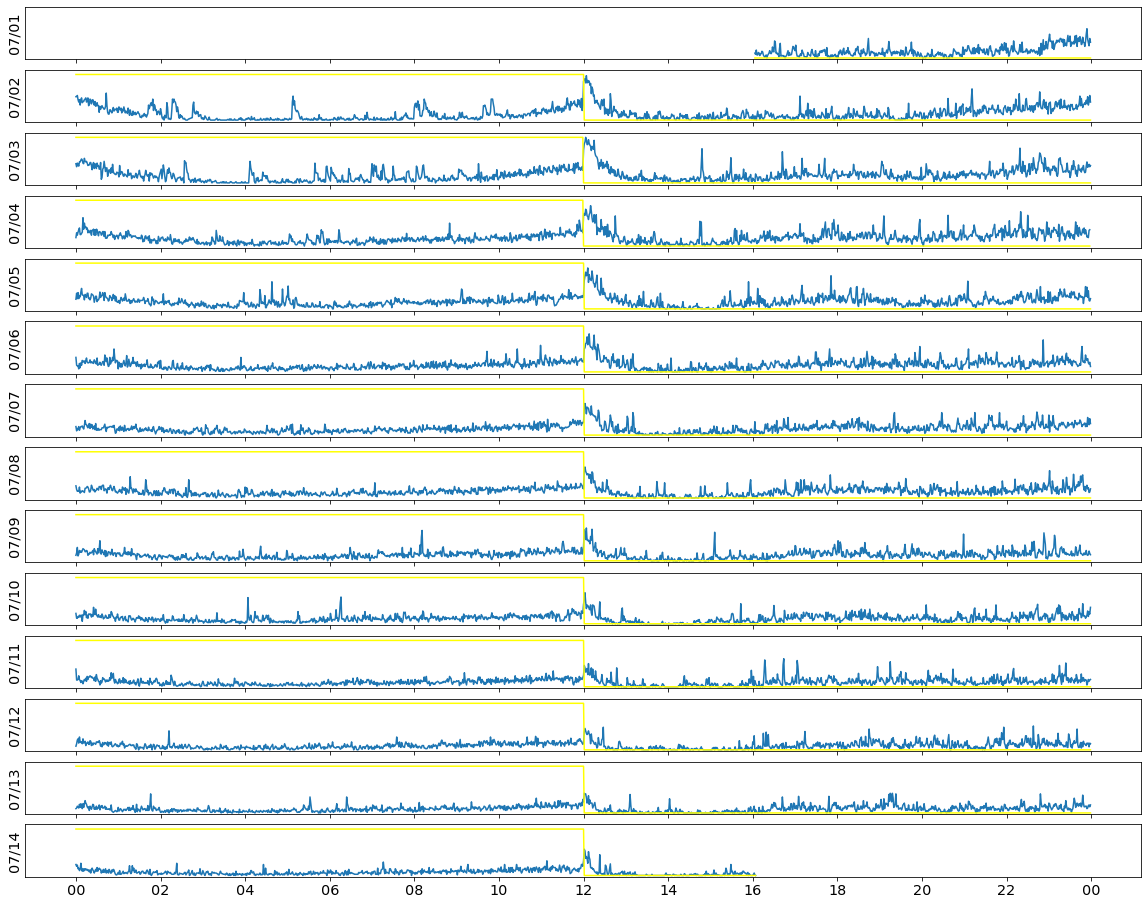

In [121]:
actogram(mutant_df)

To show the actogram for a single fly, specify the fly column

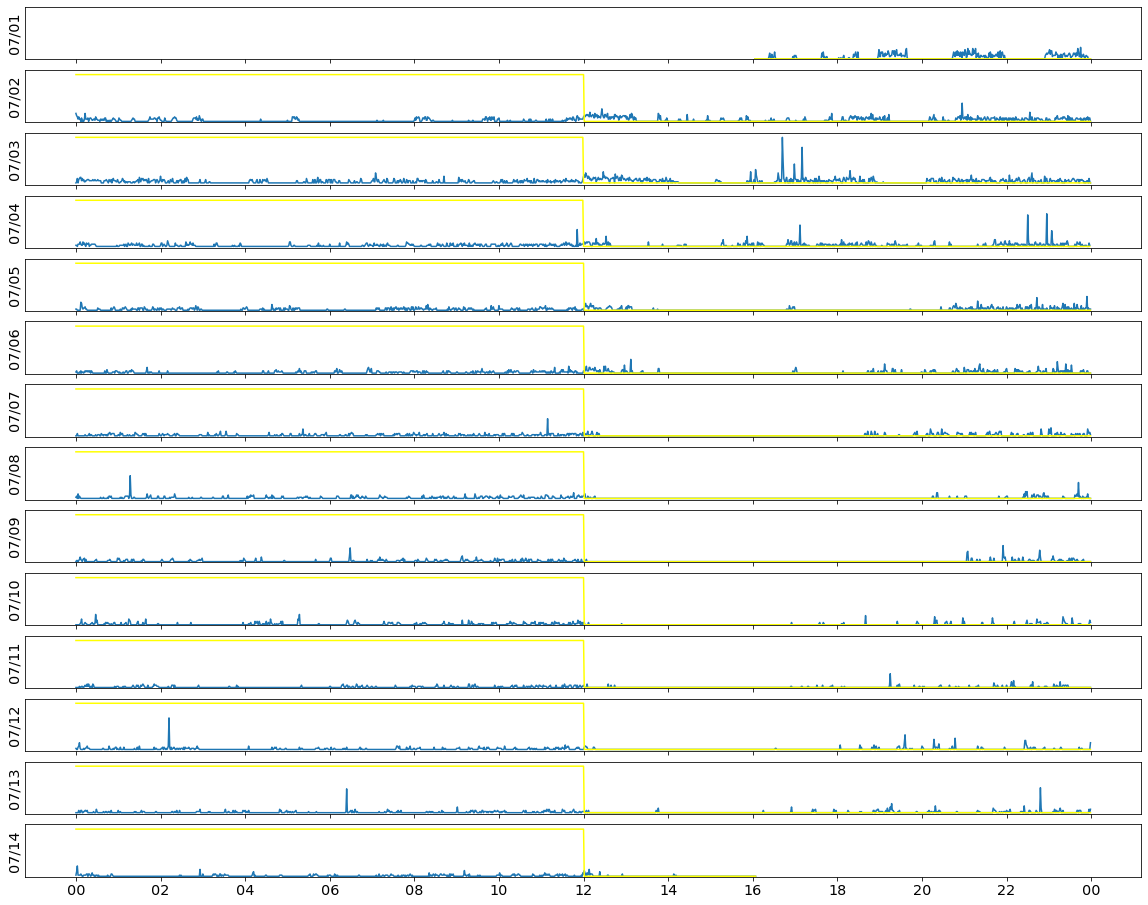

In [122]:
actogram(mutant_df, 'fly_0')

To see a literal representation of the data set `zg_faithful=False`. 

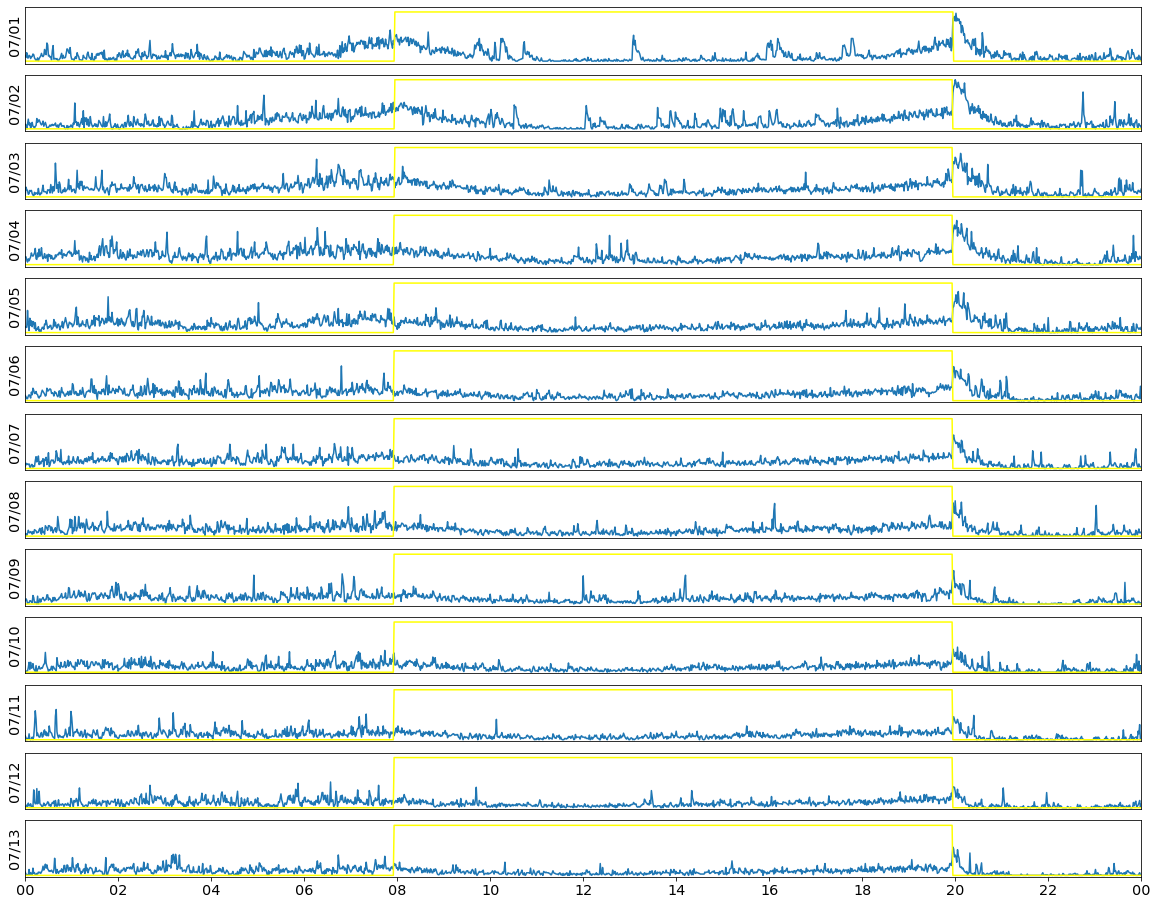

In [123]:
actogram(mutant_df, zg_faithful=False)

## Sleep actogram

You can use actograms to inspect what is classified as sleep using `sleep_filter`

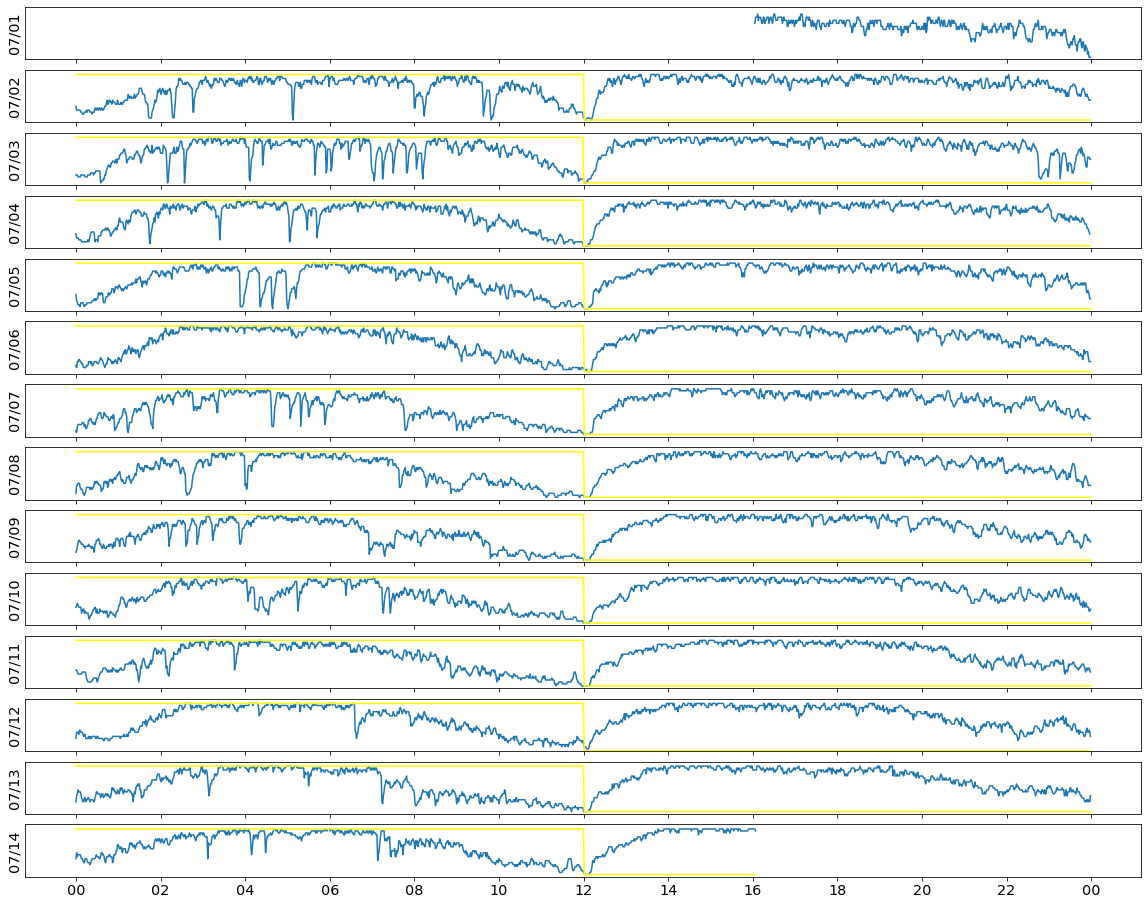

In [124]:
actogram(sleep_filter(control_df))

In [125]:
actogram(sleep_filter(control_df), 'fly_11')

You can also look at bouts using `bout_filter`, although this tends to be less useful due to how bouts are represented (as the number of timepoints at the start of the bout)

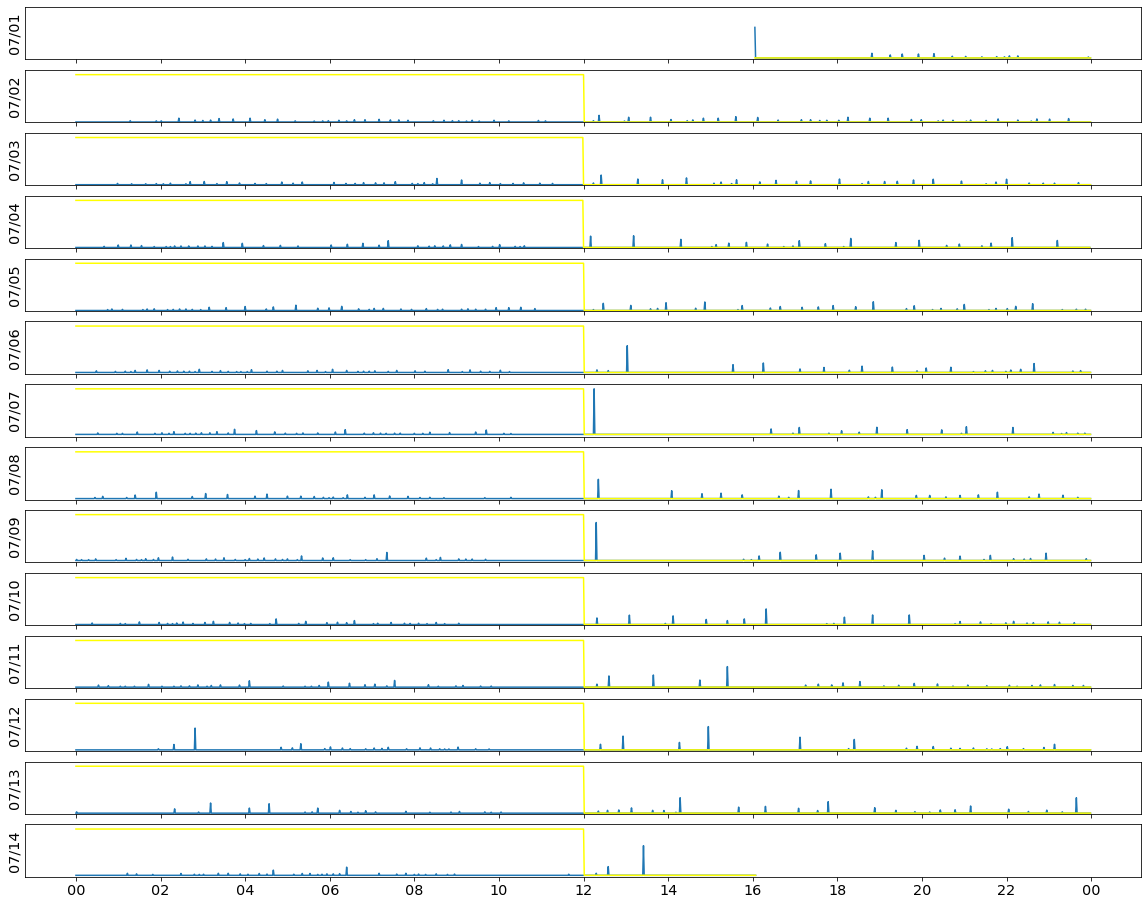

In [126]:
actogram(bout_filter(control_df), 'fly_10')

## Chronologically faithful actogram

Setting 

# Zeitgeber plot

A plot of sleep or activity averaged across all flies and days and supporting any number of genotypes and trials

By default, we're only looking at complete zietgeber days here (start and end of dataset are discarded). That slicing happened when `mutant_zg_df` and `control_zg_df` where instantiated.

Later I'll show you how to include the incomplete days at the start and end of the dataset.

## A note on trial support 

There are two interfaces to `zeitgeber_fig`:

 - `single_trial_zeitgeber_fig` which is a simplified interface only supporting a single trial per genotype, and
 - `zeitgeber_fig` the full interface supporting multiple trials per genotype

For now we're looking at the simplified interface. [Later](#Multiple-trials-per-genotype), I'll show you how trials work.

In [19]:
single_trial_zeitgeber_fig?

Signature:
single_trial_zeitgeber_fig(
    zg_dfs,
    labels,
    show='sleep',
    days=None,
    start_time=None,
    end_time=None,
    fast=True,
    fig_size=[6.4, 4.8],
    **kwargs,
)
Docstring:
Simplified interface into zeitgeber_fig supporting only a single trial for each a genotype

Args:
  zg_dfs: list of zeitgeber dataframes, one for each genotype - [pd.DataFrame]
    as returned by sleep_analysis.analysis.make_zeitgeber_df
  labels: list of labels corresponding to dataframes, one for each genotype - [str]
  show: (optional) select whether to plot either sleep or activity - str, one of ['sleep', 'activity']
  days: (optional) day or days to average over. By default all days are used - [int] or int
    Can either select one day (with a single int), all days (by default) or a list of days
  start_time: (optional) zeitgeber start time - timedelta
  end_time: (optional) zeitgeber end time - timedelta
  fast: (optional) if True don't plot confidence intervals  - bool
  kwargs: 

/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"
/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"


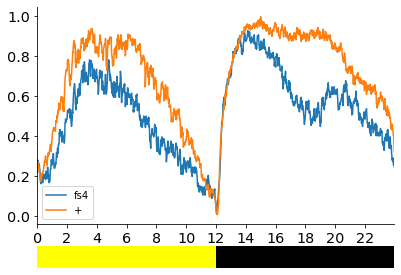

In [20]:
fig = single_trial_zeitgeber_fig([mutant_zg_df, control_zg_df], ['fs4', '+'])

## General usage

### Choosing whether to plot sleep or activity

The `show` kwarg selects whether sleep or activity are plotted. By defaults sleep is shown.

/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"
/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"


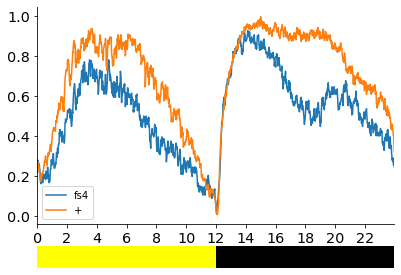

In [21]:
fig = single_trial_zeitgeber_fig([mutant_zg_df, control_zg_df], ['fs4', '+'], show='sleep')

In [22]:
fig = single_trial_zeitgeber_fig([mutant_zg_df, control_zg_df], ['fs4', '+'], show='activity')

/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"
/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"


### Slicing

`sleep_fig` has support for slicing of days or times or both but it works in a kind of funky way. We sliced the raw dataframes (`mutant_df` and `control_df`) earlier using absolute datetimes, but zeitgeber dataframes do not use absolute datetimes for their index. Let's look:

In [23]:
mutant_zg_df

light  fly_0  fly_1  fly_3  fly_6  fly_8  fly_10  fly_11  \
day zg_time                                                                     
0   0 days 00:00:00      1      7      0      4      2      3       2       2   
    0 days 00:01:00      1      5      3      3      2      2       2       1   
    0 days 00:02:00      1      4      5      5      2      2       4       3   
    0 days 00:03:00      1      2      4      3      2      0       2       1   
    0 days 00:04:00      1      4      2      3      5      0       2       2   
...                    ...    ...    ...    ...    ...    ...     ...     ...   
11  0 days 23:55:00      0      0      0      0      0      0       1       0   
    0 days 23:56:00      0      0      3      0      1      0       2       1   
    0 days 23:57:00      0      3      3      0      0      0       3       0   
    0 days 23:58:00      0      1      0      0      2      2       0       0   
    0 days 23:59:00      0      3      0      5      1      0       0       0   

                     fly_14  fly_15  fly_20  fly_21  fly_22  fly_28  fly_29  \
day zg_time                                                                   
0   0 days 00:00:00       4       3       2       0       3       2       0   
    0 days 00:01:00       2       3       4       1       2       4       0   
    0 days 00:02:00       4       2       2       1       1       0       0   
    0 days 00:03:00       3       2       1       2       2       3       0   
    0 days 00:04:00       3       0       1       1       2       1       0   
...                     ...     ...     ...     ...     ...     ...     ...   
11  0 days 23:55:00       0       0       2       0       0       3       1   
    0 days 23:56:00       1       0       1       0       2       0       1   
    0 days 23:57:00       0       0       1       0       1       1       1   
    0 days 23:58:00       0       0       1       0       1       1       2   
    0 days 23:59:00       1       0       0       0       0       0       0   

                     fly_30  fly_31  
day zg_time                          
0   0 days 00:00:00       1       4  
    0 days 00:01:00       2       3  
    0 days 00:02:00       3       3  
    0 days 00:03:00       2       5  
    0 days 00:04:00       1       3  
...                     ...     ...  
11  0 days 23:55:00       1       0  
    0 days 23:56:00       0       0  
    0 days 23:57:00       0       0  
    0 days 23:58:00       0       0  
    0 days 23:59:00       0       3  

[17279 rows x 17 columns]

Zeitgeber dataframe use day indices and 24h time within a day instead of absolute datetimes.

We can restrict our sleep plot to a time window within a day like this:

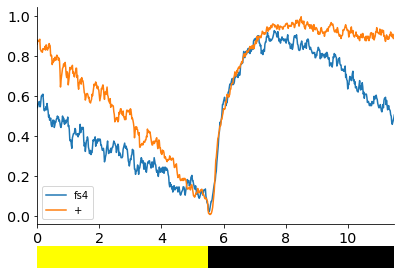

In [24]:
fig = single_trial_zeitgeber_fig(
    [mutant_zg_df, control_zg_df], 
    ['fs4', '+'],
    start_time=timedelta(hours=6, minutes=30),
    end_time=timedelta(hours=18)
)

To select a subset of days to average across:

In [25]:
fig = single_trial_zeitgeber_fig(
    [mutant_zg_df, control_zg_df], 
    ['fs4', '+'],
    days=[0, 1, 5, 8]
)

Or we can combine these options:

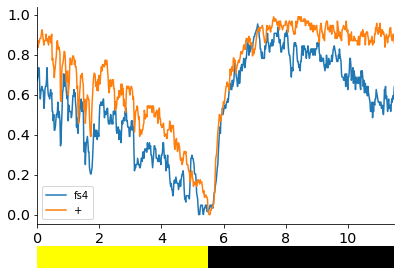

In [26]:
fig = single_trial_zeitgeber_fig(
    [mutant_zg_df, control_zg_df], 
    ['fs4', '+'],
    days=[0, 1, 5, 8],
    start_time=timedelta(hours=6, minutes=30),
    end_time=timedelta(hours=18)
)

### Confidence intervals

By default, `zeitgeber_fig` only plots mean sleep. To include confidence intervals, set `fast=False`

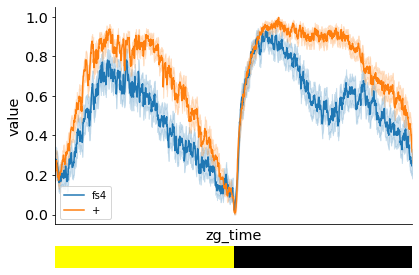

In [27]:
fig = single_trial_zeitgeber_fig(
    [mutant_zg_df, control_zg_df], 
    ['fs4', '+'],
    fast=False
)

### Specifying line color

Use the `colors` kwarg to manually specify line color. `colors` must be a list with the same length as `zg_dfs`, one color per genotype. [Here is a list of the colors you can use](https://matplotlib.org/stable/gallery/color/named_colors.html).  

/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"
/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"


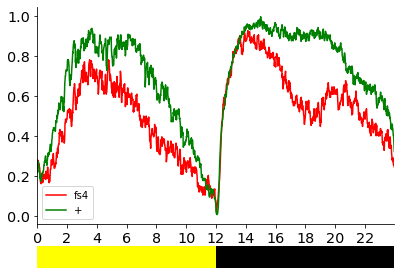

In [28]:
fig = single_trial_zeitgeber_fig(
    [mutant_zg_df, control_zg_df], 
    ['fs4', '+'],
    colors=['red', 'green']
)

### Legend placement

Legend placement can be manually overriden with the `legend_placement` argument, which has identical usage for all plots. Placement options are specified [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)

/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"
/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"


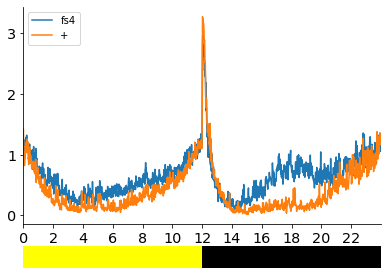

In [29]:
fig = single_trial_zeitgeber_fig(
    [mutant_zg_df, control_zg_df], 
    ['fs4', '+'],
    legend_placement='upper left', 
    show='activity'
)

### Changing plot appearance

Finally, `zeitgeber_fig` accepts any number of additional keyword arguments that are passed to matplotlib. For instance, line size can be adjusted with:

/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"
/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"


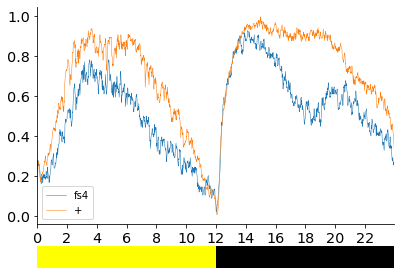

In [30]:
fig = single_trial_zeitgeber_fig(
    [mutant_zg_df, control_zg_df], 
    ['fs4', '+'],
    linewidth=0.5
)

## Including incomplete days

To include the incomplete zeitgeber day at the start (or end) of the dataset, we need to construct zeitgeber dataframes from the raw dataframe with `include_incomplete=True` (it's false by default)

In [31]:
mutant_zg_inc_df = make_zeitgeber_df(mutant_df, include_incomplete=True)
control_zg_inc_df = make_zeitgeber_df(control_df, include_incomplete=True)

Due to a quirk of how incomplete days are handled under the hood, it looks like everyone's sleeping for the first 8.5 hours of this data, while in fact there is no data. 

I haven't fixed this yet because it's annoying. But let me know if this plot is going in the paper and I'll take care of it.

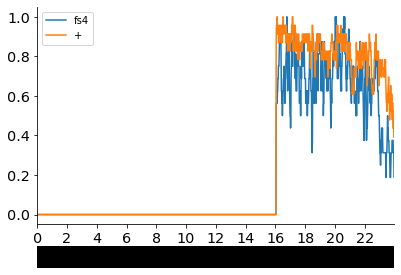

In [32]:
fig = single_trial_zeitgeber_fig(
    [mutant_zg_inc_df, control_zg_inc_df],
    ['fs4', '+'],
    days=[0],
)

It's hard to see what's going on here with the default figure size. Let's stretch things out

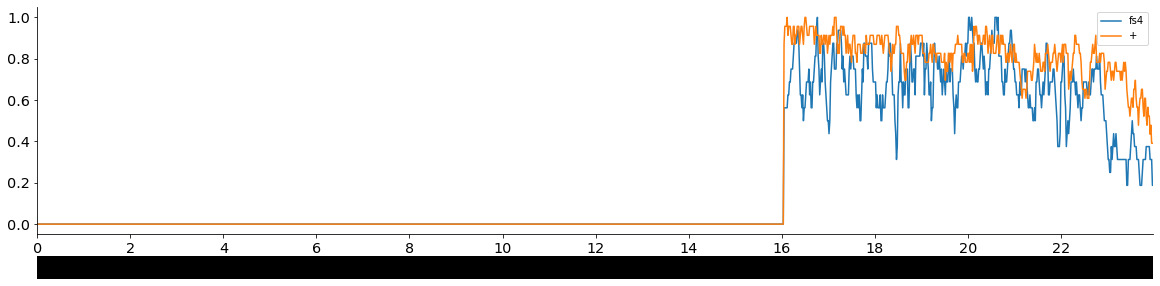

In [33]:
fig = single_trial_zeitgeber_fig(
    [mutant_zg_inc_df, control_zg_inc_df],
    ['fs4', '+'],
    days=[0],
    fig_size=(20, 5)
)

Things are noisy, as is to be expected for a single day. Personally I find the activity data easier to read than this (which is looking at `activity == 0` averaged over flies). I can also implement binning over a few minutes to smooth things out. Let me know

## Multiple trials per genotype

`zeitgeber_fig` is doing all the work under the hood, so everything we've looked at with `single_trial_zeitgeber_fig` applies to `zeitgeber_fig`. The only difference is in the form of the arguments `zg_dfs` and `days`.

Suppose we have 2 trials for genotype 1 and 1 trial for genotype 2. To express this, we use a list of lists - the list of trials for each genotype:

```
zg_dfs = [[genotype_1_trial_1_zg_df, genotype_1_trial_2_zg_df], [genotype_2_trial_1_zg_df]]
```

Easy enough. Things get a little messier for the `days` argument. In the general case, we could select a different set of days for each trial, for each genotypes. Therefore we need a list of lists of lists - the list of day indices, for each trial, for each genotype:

```
days = [[[1,2,3], [4,5]], [6]]
```

In [24]:
genotype_1_trial_1_zg_df = mutant_zg_df
genotype_1_trial_2_zg_df = mutant_zg_df

genotype_2_trial_1_zg_df = control_zg_df

/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"


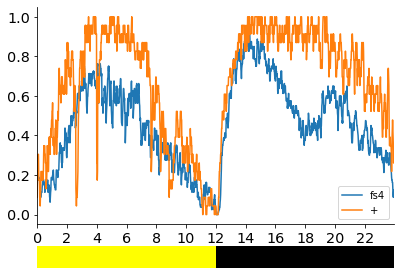

In [35]:
fig = zeitgeber_fig(
    [
        [genotype_1_trial_1_zg_df, genotype_1_trial_2_zg_df],
        [genotype_2_trial_1_zg_df]
    ],
    ['fs4', '+'],
    days=
    [
        [
            [1,2,3],
            [4, 5]
        ],
        [
            [6]
        ]
        
    ]
)

There are two more options for `days`. You can select a single day from all trials and genotypes with an `int`:

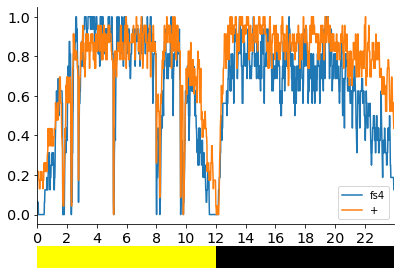

In [36]:
fig = zeitgeber_fig(
    [
        [genotype_1_trial_1_zg_df, genotype_1_trial_2_zg_df],
        [genotype_2_trial_1_zg_df]
    ],
    ['fs4', '+'],
    days=0
)

Or you can omit it entirely to select all days from all trials and genotypes

/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"
/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/plotting.py:426: UserWarning: Mismatched sample lengths, discarding 1 timepoints
  f"Mismatched sample lengths, discarding {max(sample_tps) - min(sample_tps)} timepoints"


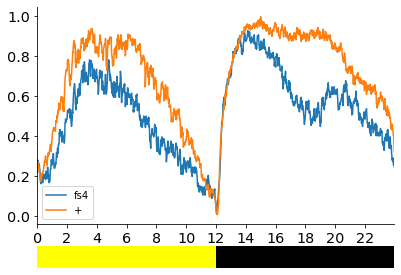

In [37]:
fig = zeitgeber_fig(
    [
        [genotype_1_trial_1_zg_df, genotype_1_trial_2_zg_df],
        [genotype_2_trial_1_zg_df]
    ],
    ['fs4', '+']
)

# Per diem sleep plot

Total minutes of sleep per day, averaged across flies

Like sleep plot, uses only complete zeitgeber days and supports multiple trials

In [38]:
per_diem_fig?

Signature:
per_diem_fig(
    zg_dfs,
    labels,
    start_time=None,
    end_time=None,
    start_day=None,
    end_day=None,
    fig_size=[6.4, 4.8],
    colors=None,
    legend_placement='best',
    legend=True,
    **kwargs,
)
Docstring:
Figure level plot of total sleep per diem

Args:
  zg_dfs: list of list of zeitgeber dataframes - [[pd.DataFrame]]
    as returned by sleep_analysis.analysis.make_zeitgeber_df
    Supports multiple trials for each genotype like this
      [[genotype_1_trial_1, genotype_1_trial_2], [genotype_2_trial_1, genotype_2_trial_2]]
  labels: list of labels corresponding to dataframes, one for each genotype - [str]
  start_time: (optional) zeitgeber start time - timedelta
  end_time: (optional) zeitgeber end time - timedelta
  start_day: (optional) by default all days are used - int
  end_day: (optional) by default all days are used - int
  fig_size: (optional) passed to matplotlib.pyplot.subplots - list
  colors: (optional) list of color labels passed to mat

## Single trial per genotype

Same deal as `sleep_plot` here, requires a list of trials for each genotype. 

The arguments aren't as complicated, so only one interface this time, `per_diem_fig`

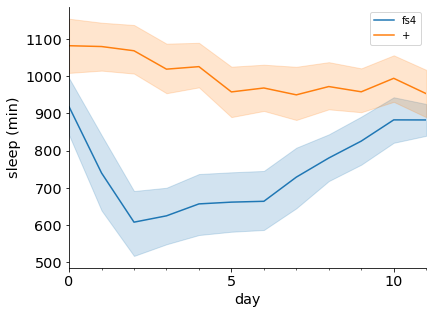

In [39]:
fig = per_diem_fig(
    [[mutant_zg_df], [control_zg_df]],
    labels=['fs4', '+'] 
)

Same option for `start_time` and `end_time` as `sleep_plot`, but the day selection works a little differently. Instead of the complicated nested list situation, the same `start_day` and `end_day` are used across all trials

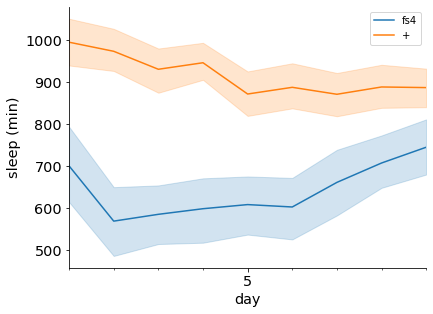

In [40]:
fig = per_diem_fig(
    [[mutant_zg_df], [control_zg_df]],
    labels=['fs4', '+'],
    start_time=timedelta(hours=1),
    end_time=timedelta(hours=22),
    start_day=1,
    end_day=9
)

## Multiple trials per genotype

Same convention for the argument as before.

The data is aggregagated over days, so  in the case that one trial is longer than the other the extra days will have a wider confidence interval. Simple enough.

In [41]:
fig = per_diem_fig(
    [
        [genotype_1_trial_1_zg_df, genotype_1_trial_2_zg_df],
        [genotype_2_trial_1_zg_df]
    ],   
    labels=['fs4', '+'],
    start_time=timedelta(hours=1),
    end_time=timedelta(hours=22),
    start_day=1,
    end_day=9
)    

## Specifying color

Same deal as the other plots

In [42]:
fig = per_diem_fig(
    [[mutant_zg_df], [control_zg_df]],
    labels=['fs4', '+'], 
    colors=['red', 'green']
)

# Cumulative sleep plot

Total sleep per fly averaged over all days. 

The required formatting for the arguments is identical to that of `per_diem_fig`

## Single trial per genotype

In [43]:
fig = cumulative_sleep_fig(
    [[mutant_zg_df], [control_zg_df]],
    labels=['fs4', '+']
)

## Multiple trials per genotype

In [44]:
fig = cumulative_sleep_fig(
    [
        [genotype_1_trial_1_zg_df, genotype_1_trial_2_zg_df],
        [genotype_2_trial_1_zg_df]
    ],   
    labels=['fs4', '+'],
)    

## Slicing

In [104]:
fig = cumulative_sleep_fig(
    [[mutant_zg_df], [control_zg_df]],
    labels=['fs4', '+'],
    start_time=timedelta(hours=0), 
    end_time=timedelta(hours=4),
    x_labels=['ZT0-ZT4']
)

## Specifying color

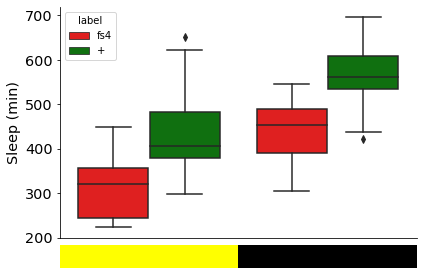

In [46]:
fig = cumulative_sleep_fig(
    [[mutant_zg_df], [control_zg_df]],
    labels=['fs4', '+'],
    colors=['red', 'green']
)

# Cumulative bout duration and length

These plots have exactly the same semantics as the cumulative sleep plot, please refer to that section for advanced usage

They show the distribution (over flies) of average bout number and duration respectively, normalized to one day. ie fs4 has on average just over 25 bouts during each light cycle

In [16]:
fig = cumulative_bout_number_fig(
    [[mutant_zg_df], [control_zg_df]],
    labels=['fs4', '+'],
    start_time=timedelta(hours=22), 
    end_time=timedelta(hours=2)
)

NameError: name 'mutant_zg_df' is not defined

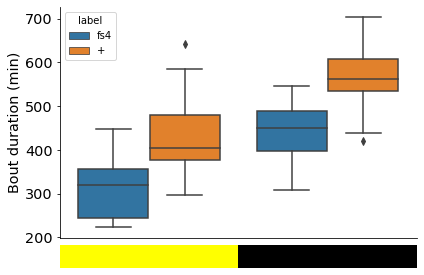

In [57]:
fig = cumulative_bout_duration_fig(
    [[mutant_zg_df], [control_zg_df]],
    labels=['fs4', '+']
)

# Stats

`cumulative_sleep`, `cumulative_bout_duration` and `cumulative_bout_number` return dataframes in the format expected by `pingouin` (stats library)

## ANOVA

Follow the flowchart



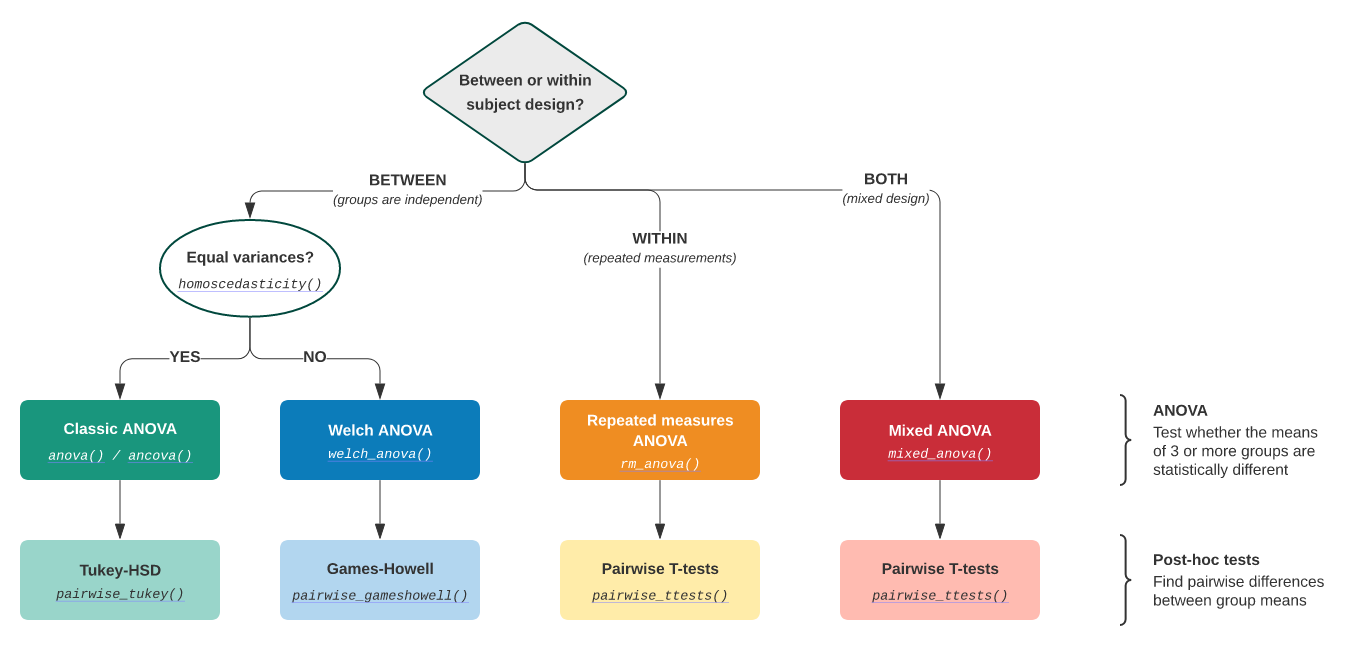

This analysis works for 2 or more groups. 

Let's load another dataset so we can see how it looks with 3 groups.

In [186]:
mtt_df = read_data('/Users/andrew2/clandinin/sleep_analysis/data/m_tt_rb5.txt').loc[datetime(2021,9,19):datetime(2021,9,24)]
mtt_df = mortality_filter(mtt_df)
mtt_zg_df = make_zeitgeber_df(mtt_df)

Using mortality heuristic
Pruning {'fly_16', 'fly_12', 'fly_18', 'fly_25', 'fly_7', 'fly_26', 'fly_19', 'fly_22', 'fly_27', 'fly_20', 'fly_13', 'fly_4', 'fly_24', 'fly_1', 'fly_23', 'fly_5', 'fly_2', 'fly_29', 'fly_28', 'fly_21', 'fly_17', 'fly_30', 'fly_8', 'fly_14', 'fly_15', 'fly_3', 'fly_0', 'fly_6', 'fly_9'}


In [189]:
genotype_3_trial_1_zg_df = mtt_zg_df

In [190]:
cumulative_sleep_df = cumulative_sleep(
     [
        [genotype_1_trial_1_zg_df, genotype_1_trial_2_zg_df],
        [genotype_2_trial_1_zg_df],
        [genotype_3_trial_1_zg_df]
    ],   
    labels=['fs4', '+', 'tt']
)

In [192]:
light_cumulative_sleep_df = cumulative_sleep_df[cumulative_sleep_df['light'] == 'light']
dark_cumulative_sleep_df = cumulative_sleep_df[cumulative_sleep_df['light'] == 'dark']

### Check if variances are equal

In [193]:
pg.homoscedasticity(data=light_cumulative_sleep_df, dv='sleep', group='label')

W     pval  equal_var
levene  1.677972  0.19617       True

In [194]:
pg.homoscedasticity(data=dark_cumulative_sleep_df, dv='sleep', group='label')

W      pval  equal_var
levene  1.664418  0.198693       True

### Equal variance case

The homescedascticity tests, we proceed with classic ANOVA. If it fails, refer to the flowchart

In [199]:
pg.anova(data=light_cumulative_sleep_df, dv='sleep', between='label')

Source  ddof1  ddof2         F     p-unc       np2
0  label      2     55  9.721798  0.000243  0.261186

In [200]:
pg.anova(data=dark_cumulative_sleep_df, dv='sleep', between='label')

Source  ddof1  ddof2          F     p-unc       np2
0  label      2     55  10.517772  0.000136  0.276654

### Post-hoc test

ANOVA shows a statistically significant difference between the groups. To find out where the difference came from, use a post-hoc test

In [201]:
pg.pairwise_tukey(data=light_cumulative_sleep_df, dv='sleep', between='label')

A    B     mean(A)     mean(B)       diff         se         T   p-tukey  \
0    +  fs4  442.579996  361.669753  80.910243  18.755872  4.313862  0.001000   
1    +   tt  442.579996  432.658448   9.921548  42.116954  0.235571  0.900000   
2  fs4   tt  361.669753  432.658448 -70.988694  41.427930 -1.713547  0.209466   

     hedges  
0  1.162491  
1  0.140039  
2 -1.010958

In [202]:
pg.pairwise_tukey(data=dark_cumulative_sleep_df, dv='sleep', between='label')

A    B     mean(A)     mean(B)       diff         se         T   p-tukey  \
0    +  fs4  557.121733  487.320921  69.800812  15.360064  4.544305  0.001000   
1    +   tt  557.121733  537.176593  19.945140  34.491550  0.578262  0.814512   
2  fs4   tt  487.320921  537.176593 -49.855672  33.927276 -1.469486  0.313819   

     hedges  
0  1.224590  
1  0.343756  
2 -0.866967

## Non-parametric tests

Follow the flowchart

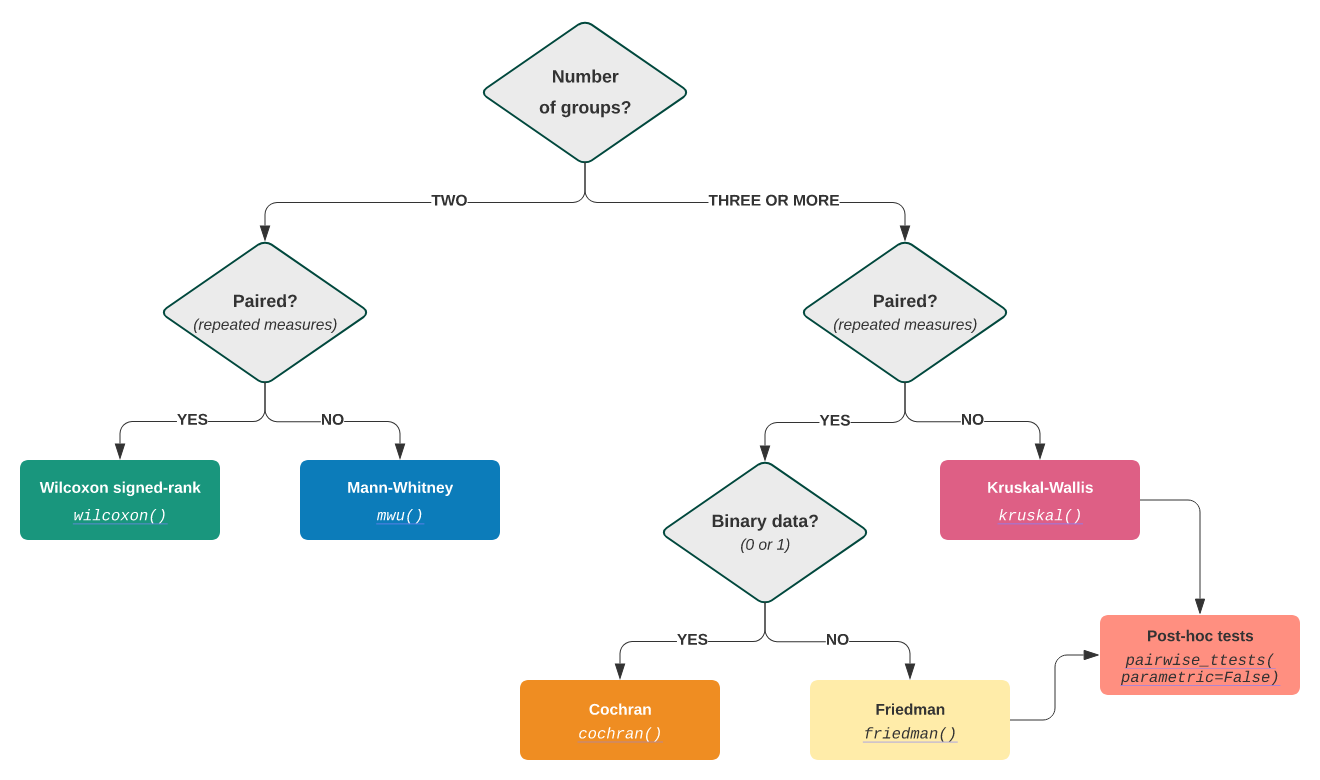

### Mann-Whitney U-test

The Mann–Whitney U test (also called Wilcoxon rank-sum test) is a non-parametric test of the null hypothesis that it is equally likely that a randomly selected value from one sample will be less than or greater than a randomly selected value from a second sample. The test assumes that the two samples are independent. 

In [203]:
pg.mwu(light_cumulative_sleep_df[light_cumulative_sleep_df['label'] == 'fs4']['sleep'], light_cumulative_sleep_df[light_cumulative_sleep_df['label'] == '+']['sleep'])

U-val alternative     p-val       RBC      CLES
MWU  152.0   two-sided  0.000235  0.586957  0.206522

### Kruskal-Wallis

In [206]:
pg.kruskal(data=light_cumulative_sleep_df, dv='sleep', between='label')

Source  ddof1          H     p-unc
Kruskal  label      2  14.561839  0.000689

#### Post-hoc

In [207]:
pg.pairwise_ttests(data=light_cumulative_sleep_df, dv='sleep', between='label', parametric=False)

Contrast    A    B  Paired  Parametric  U-val alternative     p-unc  \
0    label    +  fs4   False       False  584.0   two-sided  0.000235   
1    label    +   tt   False       False   35.0   two-sided  1.000000   
2    label  fs4   tt   False       False   20.0   two-sided  0.104745   

     hedges  
0  1.174416  
1  0.114959  
2 -1.225502

# Saving figures

You may have noticed that, in addition to plotting, the figure methods return something I've been saving in the `fig` variable. The point of that was to make it easy to save the figures to disk:

In [58]:
fig.savefig('/tmp/test_fig.pdf')

#  Dealing with glitches in the light column

As previously discussed, `make_zeitgeber_df` relies on the light column to infer zeitgeber days and is very sensitive to outliers. Let's look at what goes wrong when there are problems with the light coloumn and see how to fix it


In [59]:
glitchy_df = read_data('/Users/andrew2/clandinin/sleep_analysis/data/4th-control.txt')

## The easy, slightly sketchy way: override the light cycle

First, identify the lights on time and cycle length

In [60]:
get_lights_on_datetimes(glitchy_df)

[Timestamp('2021-10-22 16:36:00'),
 Timestamp('2021-10-22 16:38:00'),
 Timestamp('2021-10-23 07:52:00'),
 Timestamp('2021-10-24 07:51:00'),
 Timestamp('2021-10-25 07:51:00'),
 Timestamp('2021-10-26 07:51:00'),
 Timestamp('2021-10-27 07:51:00'),
 Timestamp('2021-10-28 07:51:00'),
 Timestamp('2021-10-29 07:51:00'),
 Timestamp('2021-10-30 07:51:00'),
 Timestamp('2021-10-30 22:22:00'),
 Timestamp('2021-10-31 07:51:00')]

`summarize` will tell you the cycle length. The DAMs seem to have a cycle length slightly less than 24 hours. But you may just want to leave the cycle at 24 hours, which is the default.

Then, set the light cycle.

In [61]:
relight_df = set_light_cycle(glitchy_df, timedelta(hours=7, minutes=51))

/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/utils.py:156: UserWarning: Using cycle of length 1 day, 0:00:00. Existing light cycle has average length of 0 days 23:59:51.428571428 over 7 well-formed cycles.
  f"Using cycle of length {cycle_length}. "


Or if you want to modify the cycle length

In [62]:
relight_df = set_light_cycle(glitchy_df, timedelta(hours=7, minutes=51), cycle_length=timedelta(hours=23, minutes=59, seconds=30))

/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/utils.py:156: UserWarning: Using cycle of length 23:59:30. Existing light cycle has average length of 1 days 00:00:00 over 9 well-formed cycles.
  f"Using cycle of length {cycle_length}. "


## The hard 'proper' way: fix the problems

Summarize is the first line of defense, it tells us that there are some problems with the light column in this dataset

In [63]:
summarize(glitchy_df)

General summary:

	 Data ranges from 2021-10-21 14:22:00 to 2021-10-31 17:57:00

	 14616 timepoints

	 32 flies



No missing timepoints



Light cycle:

	 9 well-formed cycles of average length 0 days 23:59:26.666666666

	 0 malformed cycles:

		 0 too short:

		 0 too long:



Let's take a look at the light column

<AxesSubplot:xlabel='date'>

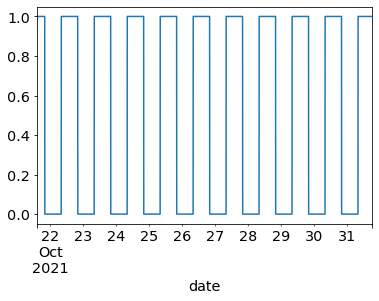

In [64]:
glitchy_df['light'].plot()

And the resulting actogram

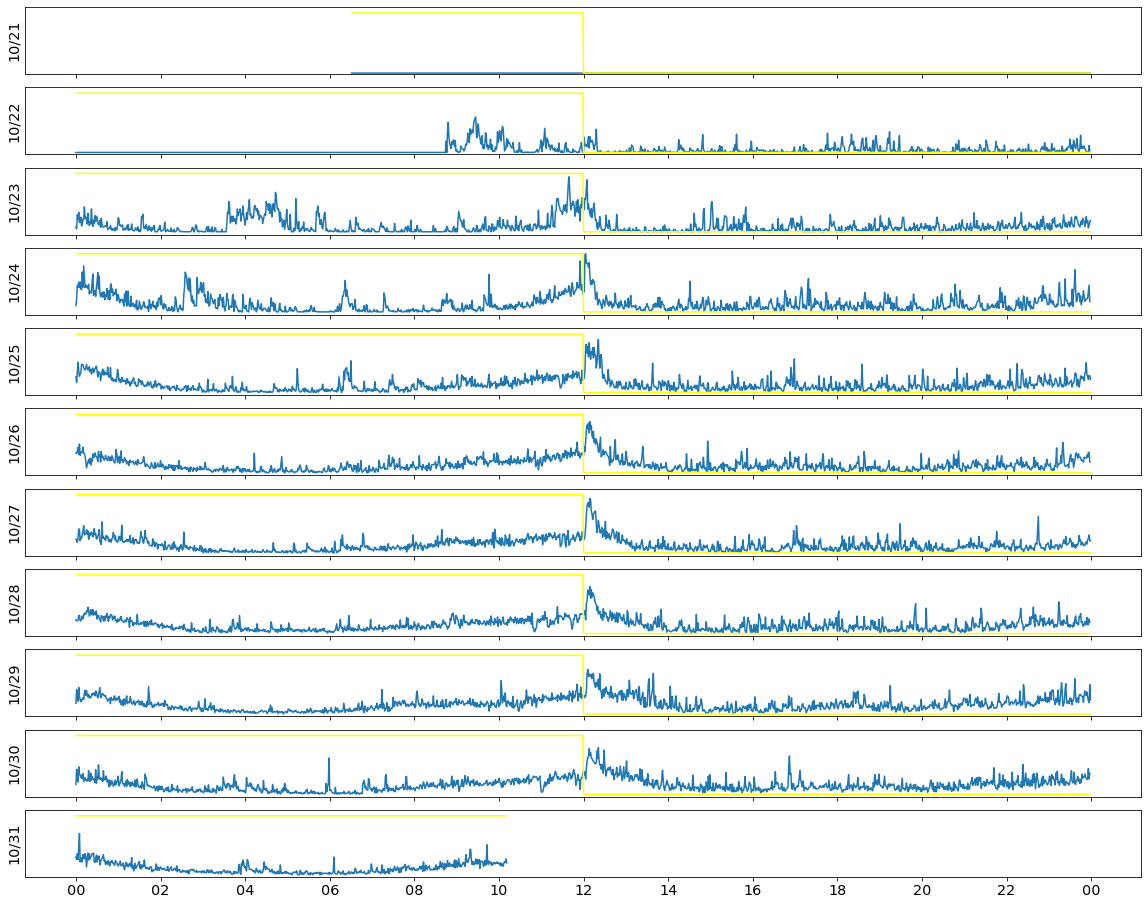

In [65]:
actogram(glitchy_df)

Not good! The date labels are nonsense, there are incomplete days, it's a mess (this happens because `make_zeitgeber_df` naively creates a day for every light cycle, regardless how short)

The glitches in the  light column must be removed. I have provided a few tools but this is unfortunately a manual process

`get_single_timepoint_glitches` is the first line of attack. It reports the indices where the light column changed sign for a single timepoint

In [66]:
get_single_timepoint_glitches(glitchy_df)

[]

Let's take a look at what the light column is doing in the neighborhood of 1575

Make sure you've read the [documentation on indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html) in pandas if you haven't already 

<AxesSubplot:xlabel='date'>

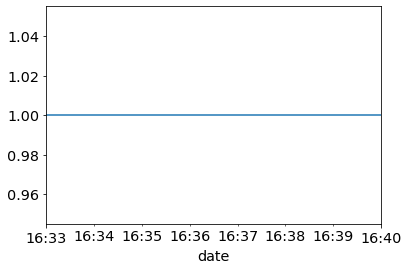

In [67]:
glitchy_df.iloc[1571:1579]['light'].plot()

This one's arbitrary. Let's say that the problem is the single timepoint of dark at 1575. We'll fix it by modifying `glitchy_df` in place. The first index is the row index, the second index is the column index (light is the first column)

In [68]:
glitchy_df.iloc[1575, 0] = 1

<AxesSubplot:xlabel='date'>

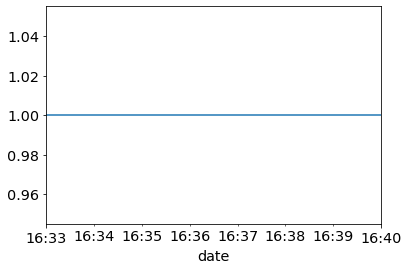

In [69]:
glitchy_df.iloc[1571:1579]['light'].plot()

Much better! Now let's look at the glitch at 13440

<AxesSubplot:xlabel='date'>

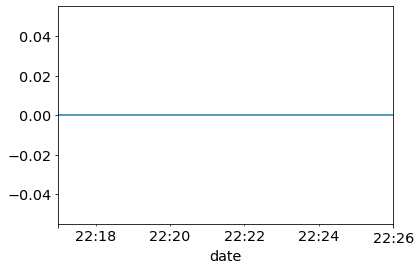

In [70]:
glitchy_df.iloc[13435:13445]['light'].plot()

The fix is clear here

In [71]:
glitchy_df.iloc[13440, 0] = 0

Let's see what summarize tells us now

In [72]:
summarize(glitchy_df)

General summary:

	 Data ranges from 2021-10-21 14:22:00 to 2021-10-31 17:57:00

	 14616 timepoints

	 32 flies



No missing timepoints



Light cycle:

	 9 well-formed cycles of average length 0 days 23:59:26.666666666

	 0 malformed cycles:

		 0 too short:

		 0 too long:



<AxesSubplot:xlabel='date'>

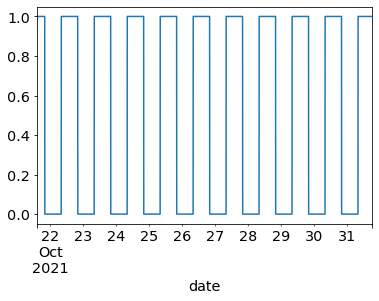

In [73]:
glitchy_df['light'].plot()

This case is also ambiguous. Inspection of `glitchy_df` will show that the dataset is all zeroes until the light cycle starts, so I'm going to truncate the entire dataset

In [74]:
glitchy_df = glitchy_df.loc[datetime(2021, 10, 22, 16, 36):]

<AxesSubplot:xlabel='date'>

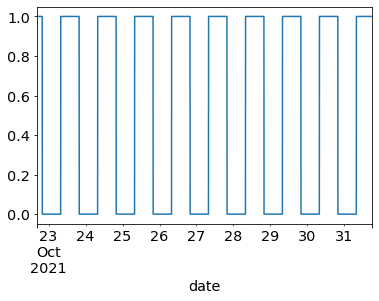

In [75]:
glitchy_df['light'].plot()

Let's check if that's resolved all of the problems

In [76]:
summarize(glitchy_df)

General summary:

	 Data ranges from 2021-10-22 16:36:00 to 2021-10-31 17:57:00

	 13042 timepoints

	 32 flies



No missing timepoints



Light cycle:

	 8 well-formed cycles of average length 0 days 23:59:30

	 0 malformed cycles:

		 0 too short:

		 0 too long:



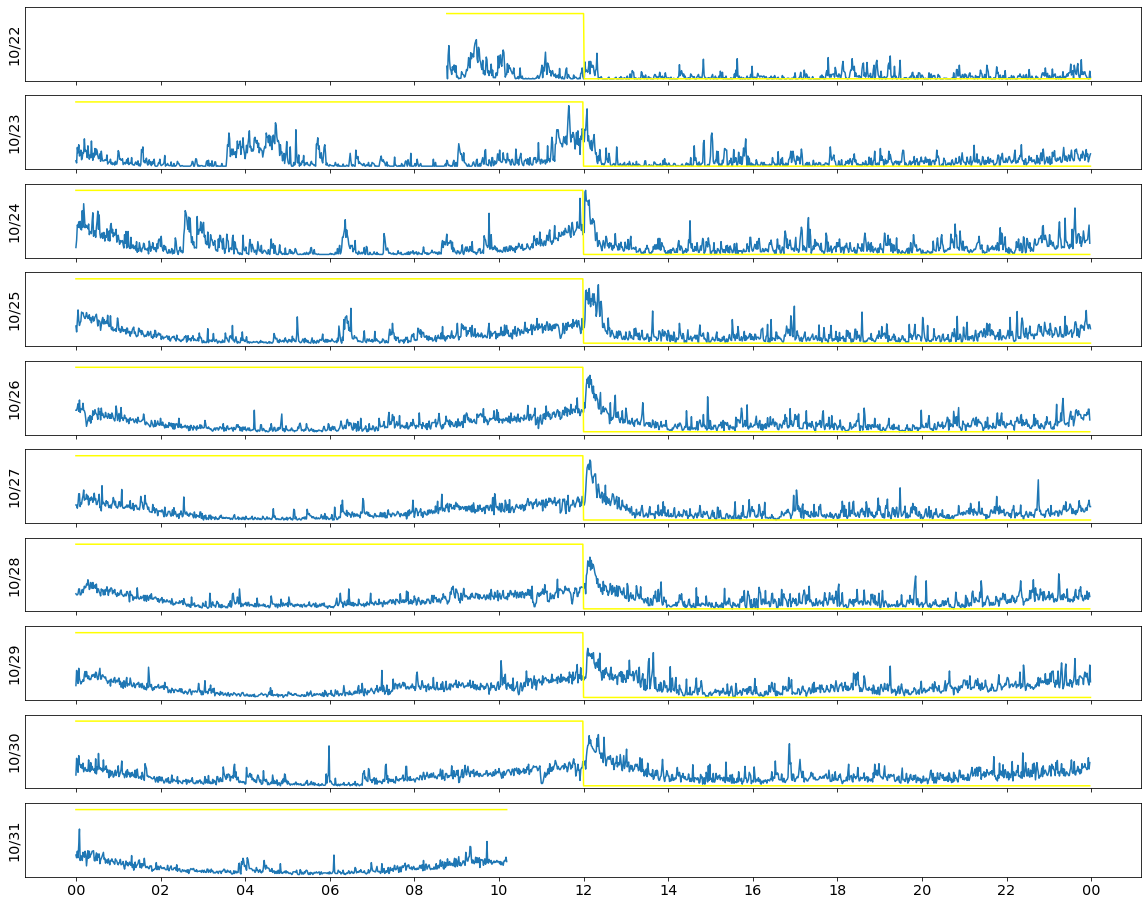

In [77]:
actogram(glitchy_df)

Great! It sure would be useful if we could save `glitchy_df`. But I haven't implemented that yet, sorry!

# Joining two datasets

One genotype in two files due to DAM failure

In [13]:
df_pt1 = read_data('/Users/andrew2/clandinin/sleep_analysis/data/85g01-wtrescue.txt')
df_pt2 = read_data('/Users/andrew2/clandinin/sleep_analysis/data/85g01-wtrescue_2.txt')

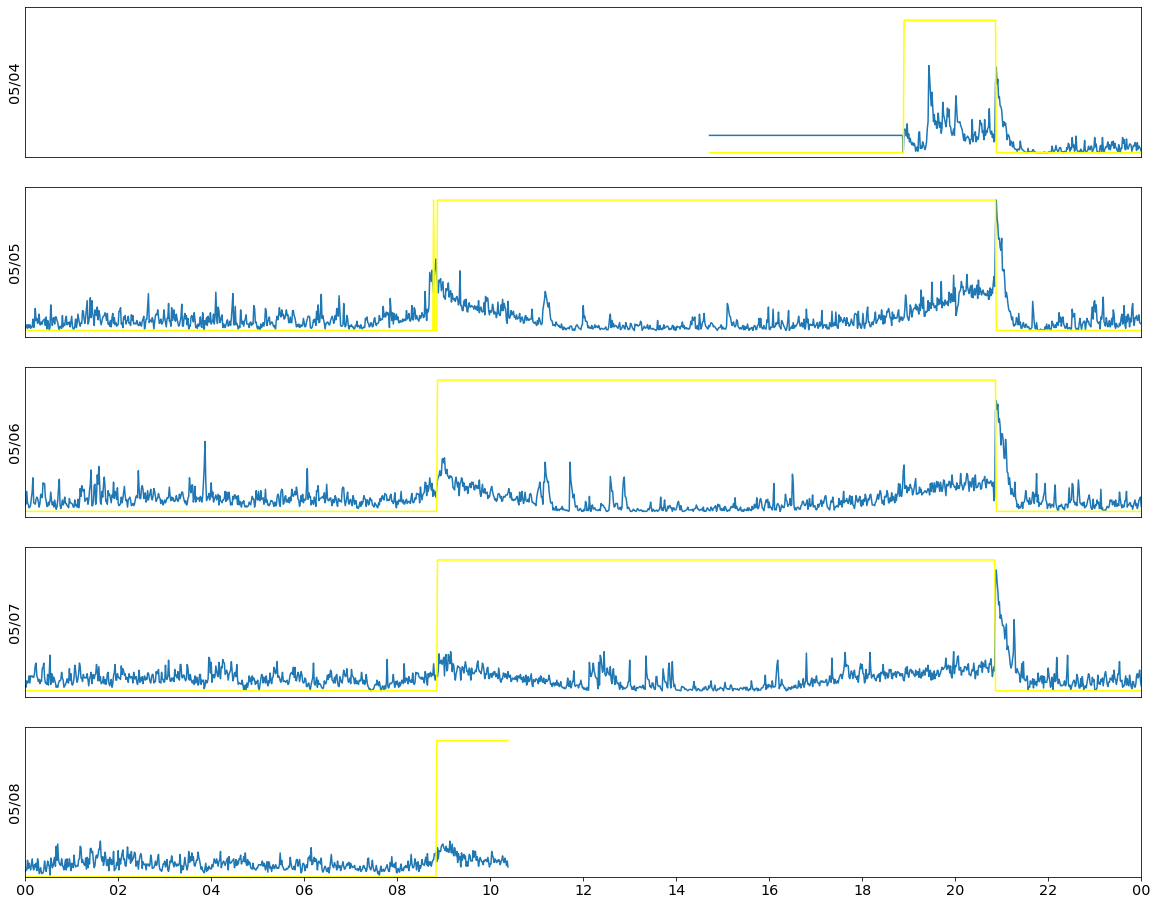

In [14]:
actogram(df_pt1, zg_faithful=False)

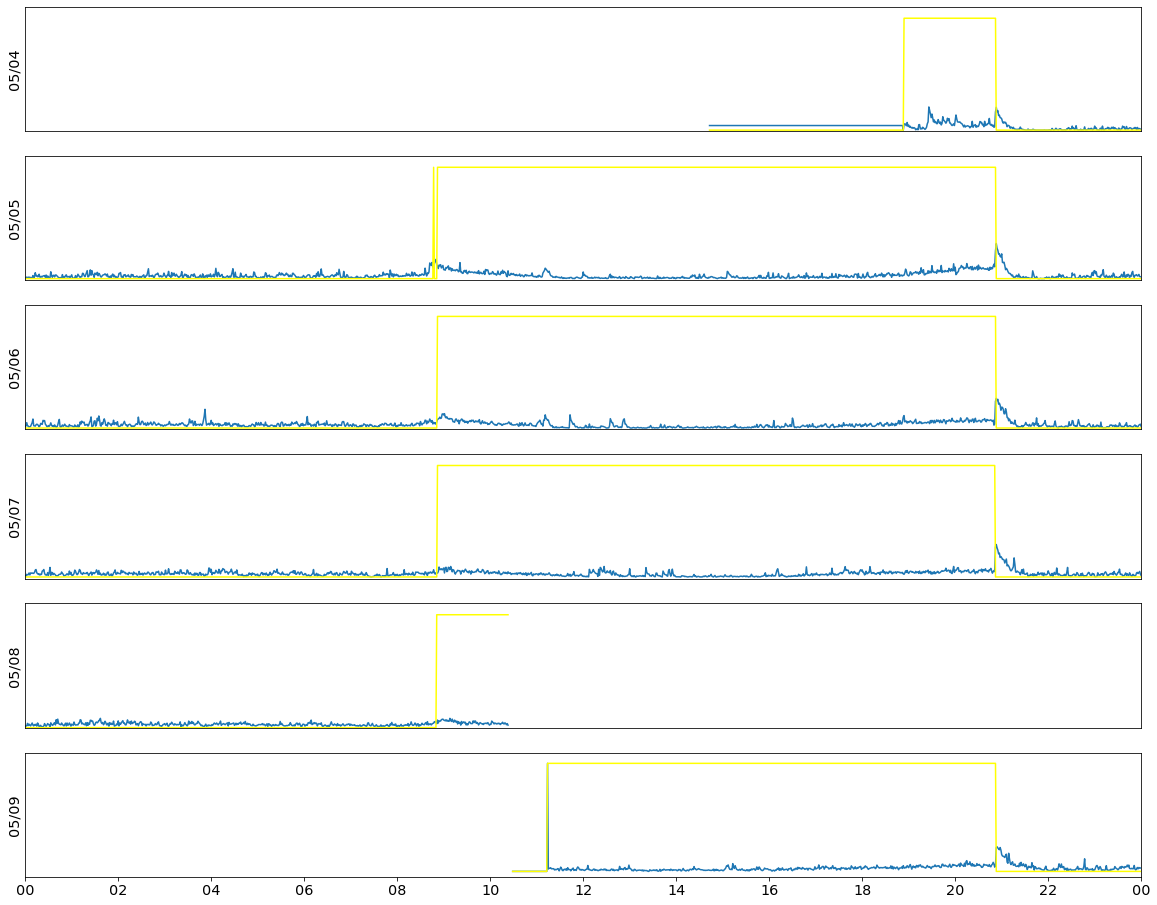

In [15]:
actogram(df_pt2, zg_faithful=False)

actogram(mutant_df, zg_faithful=False)

So `df_pt1` is a subset of `df_pt2`, the DAM continued recording to the same file once it recovered. The way to handle this is by slicing the dataset into two 'trials'.

The DAM crashes a little after 5/8:10 and recovers at 5/9:11:30 or so

In [26]:
df_trial_1 = df_pt2.loc[:datetime(2022, 5, 8, 10)]
df_trial_2 = df_pt2.loc[datetime(2022, 5, 9, 11, 30):]

Let's check that the files can be correctly parsed by `make_zeitgeber_df` now:

/Users/andrew2/clandinin/sleep_analysis/sleep_analysis/analysis.py:180: UserWarning: Achtung! Malformed light column! make_zeitgeber_df expects nearly 24 hour light cycles. See summary for more info
  "Achtung! Malformed light column! make_zeitgeber_df expects nearly 24 hour light cycles."


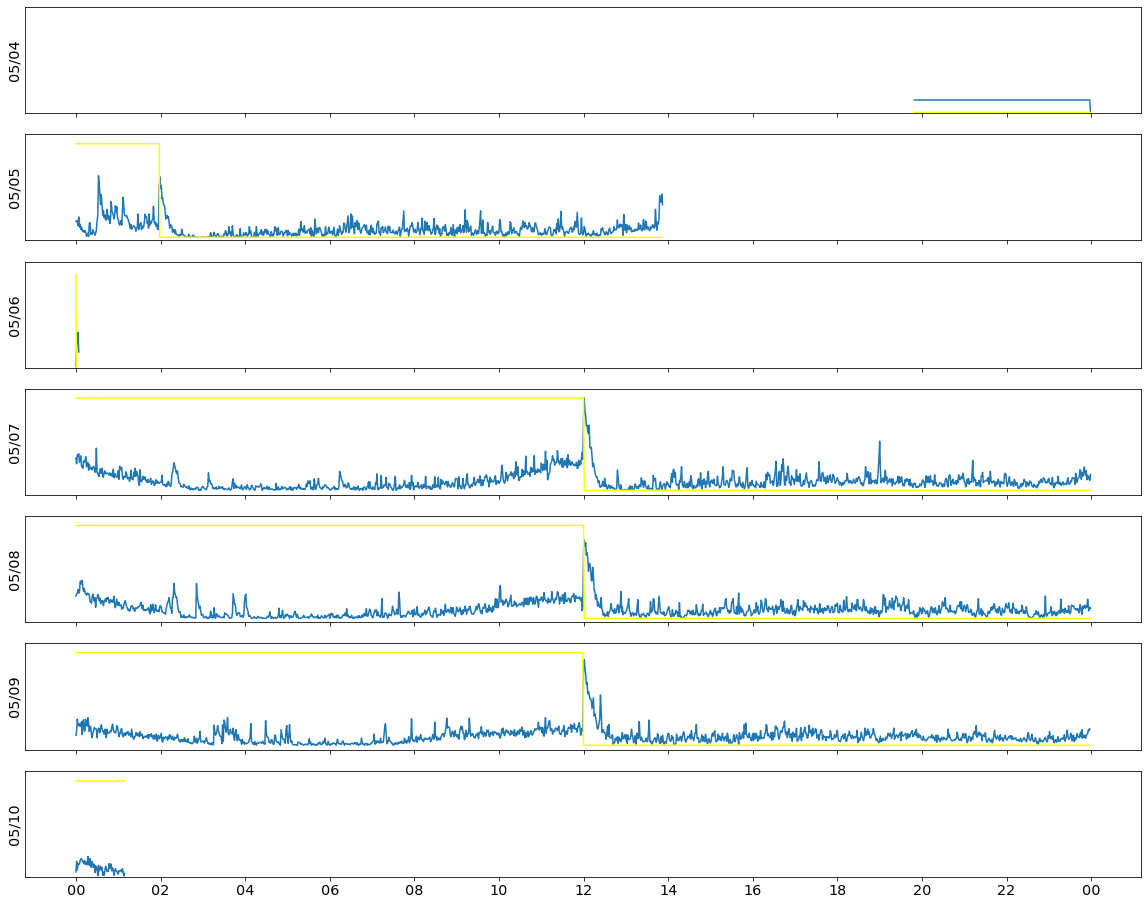

In [27]:
actogram(df_trial_1)

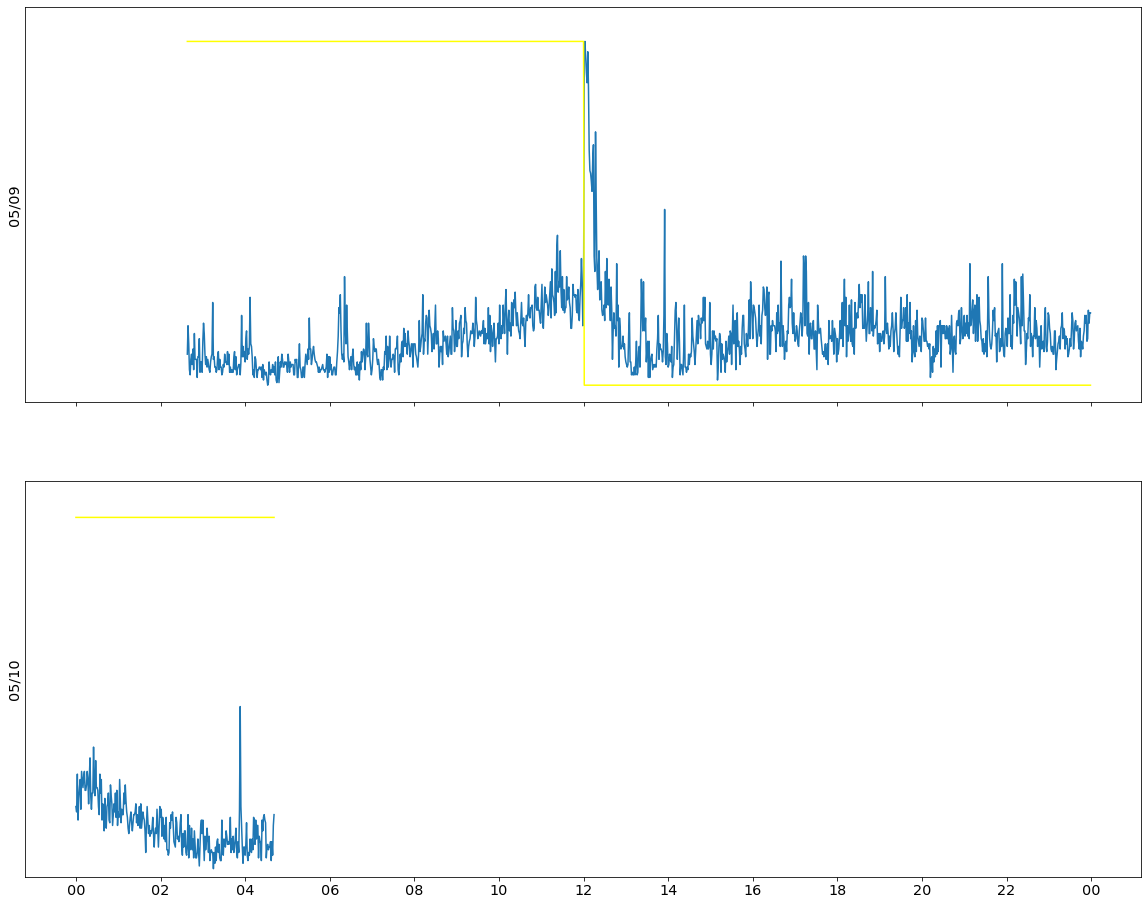

In [28]:
actogram(df_trial_2)

Whoops, the latter half of the dataset is fine, but there are two problems with the first part: a transient glitch in the light column on 5/5 and a problem at the start of the dataset where there isn't any data.

Let's do light column surgery so we don't have to throw away the first day. We'll cut out the single timepoint glitch and cut off the beginning of the data where there isn't any data.

In [29]:
get_lights_on_datetimes(df_trial_1)

[Timestamp('2022-05-04 18:54:00'),
 Timestamp('2022-05-05 08:47:00'),
 Timestamp('2022-05-05 08:52:00'),
 Timestamp('2022-05-06 08:52:00'),
 Timestamp('2022-05-07 08:52:00'),
 Timestamp('2022-05-08 08:51:00')]

In [32]:
get_single_timepoint_glitches(df_trial_1)

[1084]

<AxesSubplot:xlabel='date'>

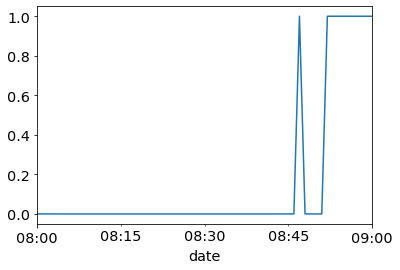

In [31]:
df_trial_1.loc[datetime(2022, 5, 5, 8):datetime(2022, 5, 5, 9), 'light'].plot()

There is a single timepoint gltich at 8:46 or so. We can patch that out.

In [36]:
df_trial_1.iat[1084, 0] = 0

<AxesSubplot:xlabel='date'>

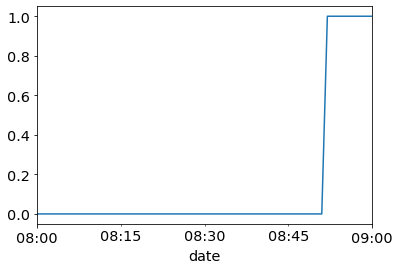

In [38]:
df_trial_1.loc[datetime(2022, 5, 5, 8):datetime(2022, 5, 5, 9), 'light'].plot()

Now we'll cut out the bit at the beginning of the recording with missing data.

In [43]:
df_trial_1 = df_trial_1.loc[datetime(2022, 5, 4, 18, 54):]

In [44]:
summarize(df_trial_1)

General summary:

	 Data ranges from 2022-05-04 18:54:00 to 2022-05-08 10:00:00

	 5227 timepoints

	 32 flies



No missing timepoints



Light cycle:

	 3 well-formed cycles of average length 0 days 23:59:40

	 0 malformed cycles:

		 0 too short:

		 0 too long:



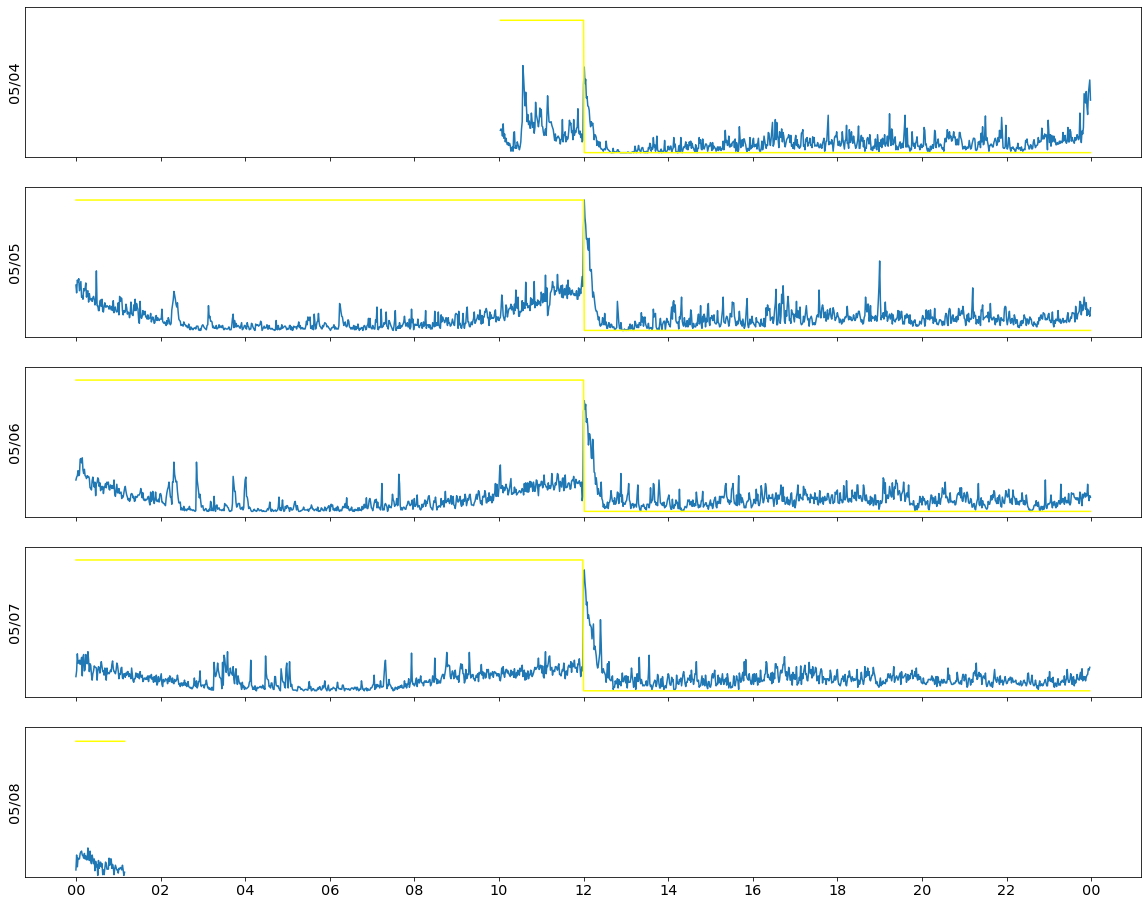

In [45]:
actogram(df_trial_1)

That fixes all of the problems. `df_trial_1` and `df_trial_2` can now be used as normal. All of the plots support multiple trials, refer to the usage examples.

# DST investigation

In [28]:
dst_df = read_data()

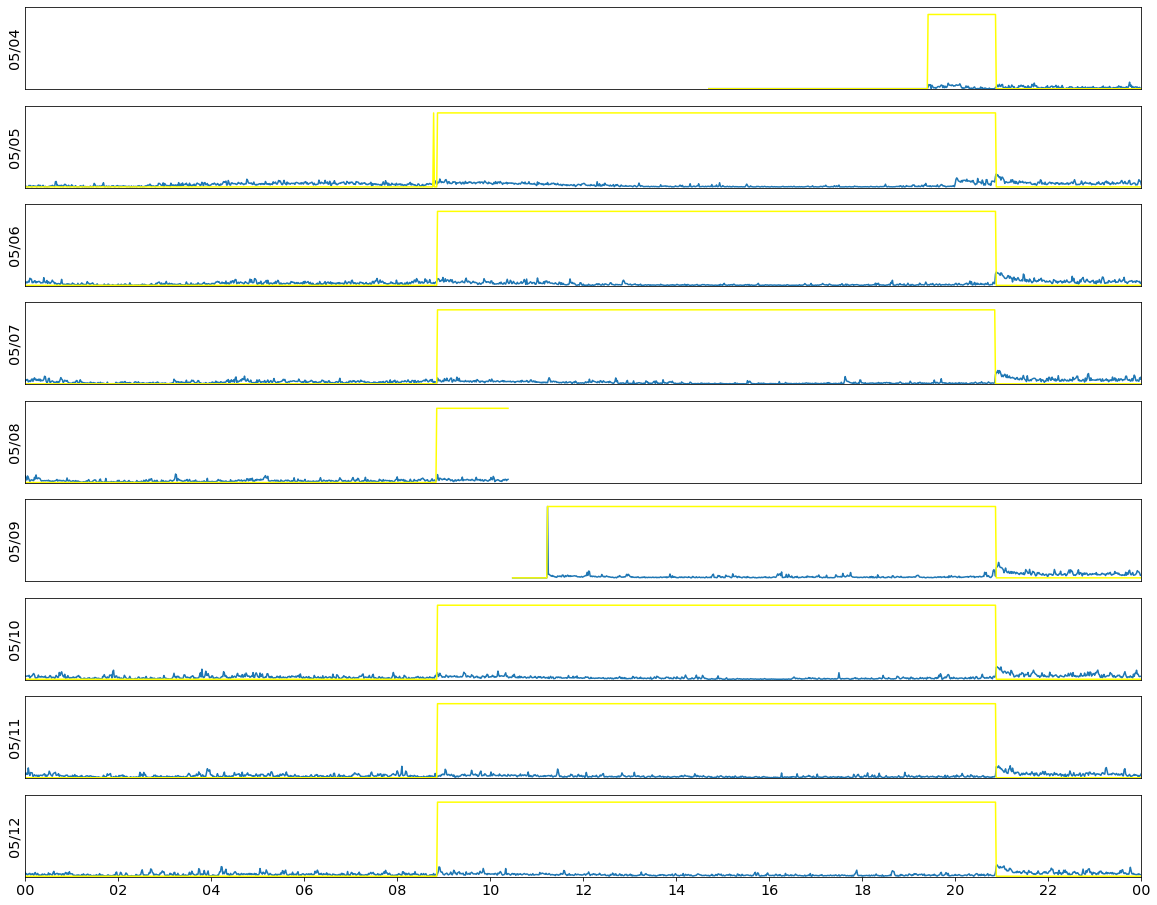

In [30]:
actogram(dst_df, zg_faithful=False)

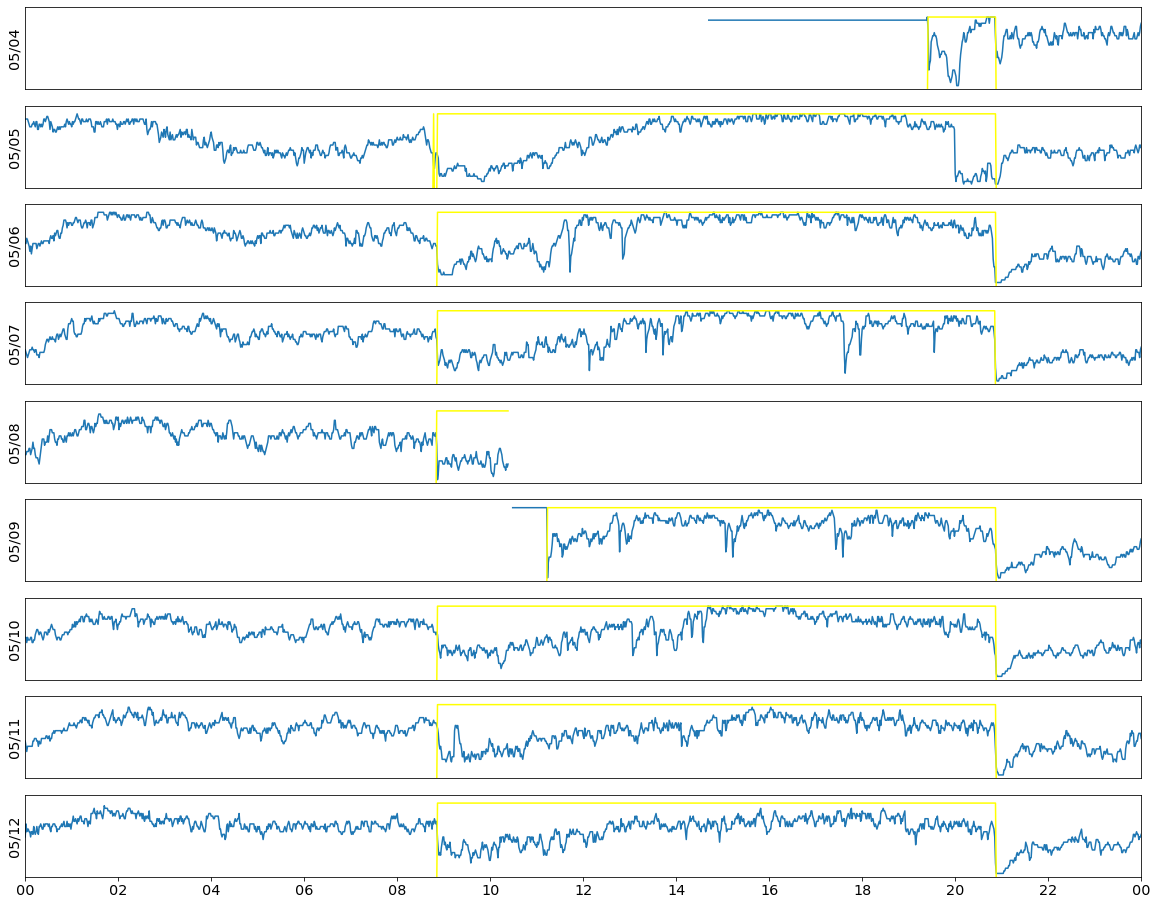

In [31]:
actogram(sleep_filter(dst_df), zg_faithful=False)

In [51]:
rescue_df = read_data('/Users/andrew2/Downloads/_85g01-56f03-wtrescue.txt')
rescue_df_trial_1 = rescue_df.loc[:datetime(2022, 5, 8, 10)]
rescue_df_trial_2 = rescue_df.loc[datetime(2022, 5, 9, 11, 30):]
rescue_df_trial_1 = rescue_df_trial_1.loc[datetime(2022, 5, 4, 19, 25):]
rescue_df_trial_1.iat[802, 0] = 0

In [75]:
rescue_df_trial_1 = mortality_filter(rescue_df_trial_1)
rescue_df_trial_2 = mortality_filter(rescue_df_trial_2)

Using mortality heuristic
Pruning {'fly_24', 'fly_27', 'fly_26', 'fly_25', 'fly_23'}
Using mortality heuristic
Pruning {'fly_24', 'fly_27', 'fly_26', 'fly_25', 'fly_23'}


In [52]:
get_single_timepoint_glitches(rescue_df_trial_1)

[]

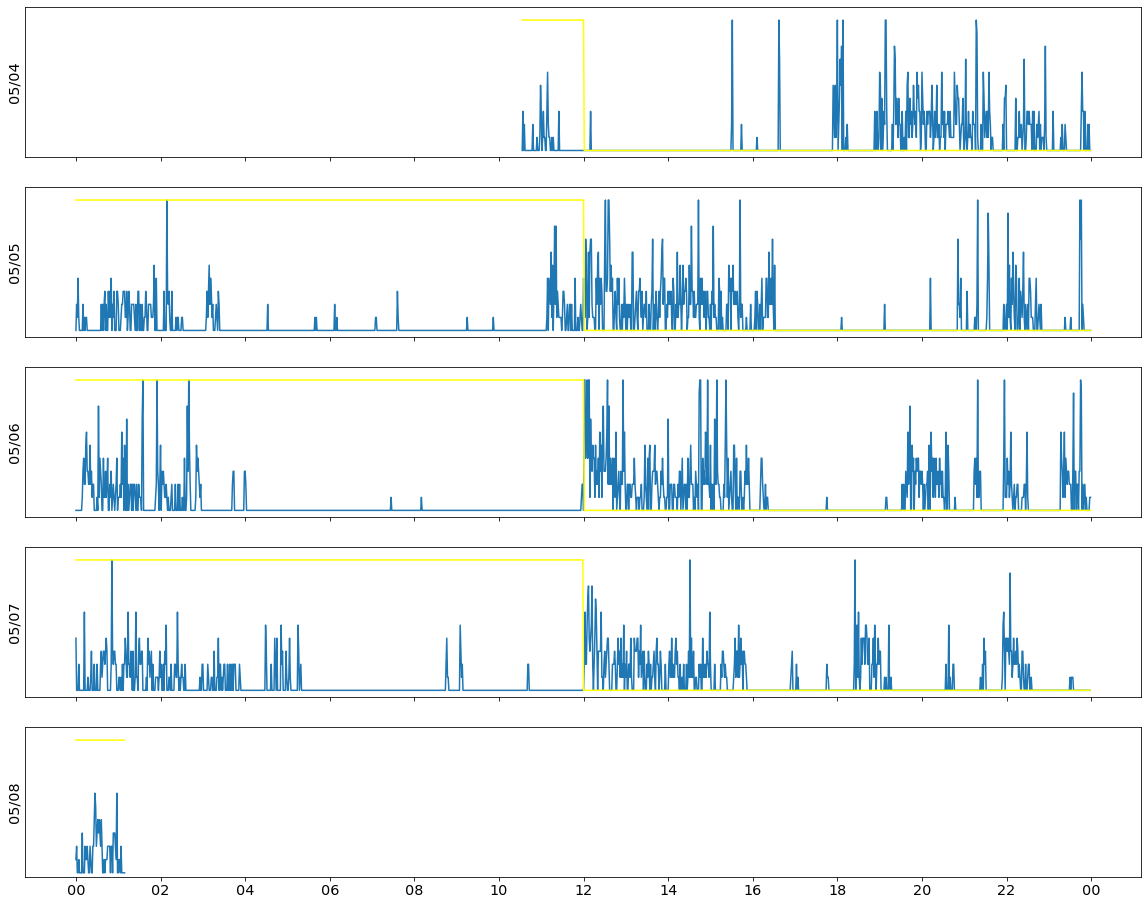

In [92]:
actogram(rescue_df_trial_1.clip(upper=10), 'fly_2')

Discarding first 0 days 13:27:00, last 0 days 01:09:00
Discarding first 0 days 21:22:00, last 0 days 01:18:00


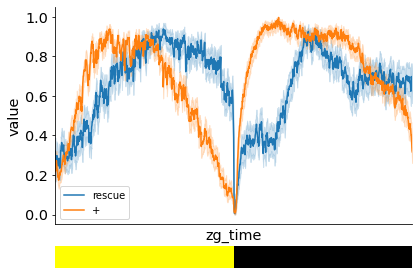

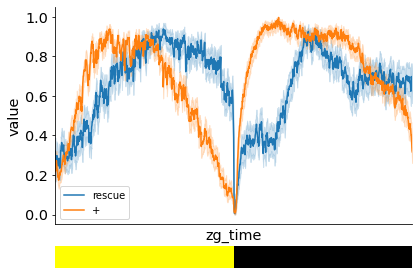

In [85]:
zeitgeber_fig([
    [make_zeitgeber_df(rescue_df_trial_1), make_zeitgeber_df(rescue_df_trial_2)], 
    [control_zg_df]
]
, ['rescue', '+'], show='sleep', fast=False)

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

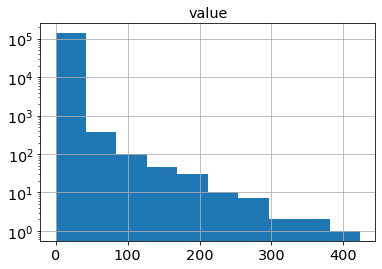

In [98]:
bout_filter(rescue_df_trial_1).loc[:, [col for col in rescue_df_trial_1.columns if col != 'light']].melt().hist(log=True) 

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

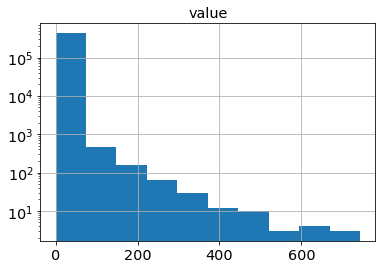

In [102]:
bout_filter(control_df).loc[:, [col for col in control_df.columns if col != 'light']].melt().hist(log=True) 

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

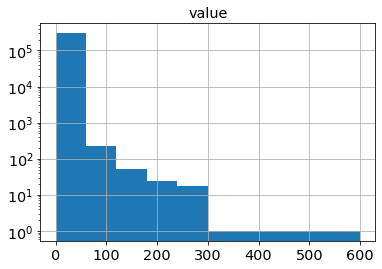

In [103]:
bout_filter(mutant_df).loc[:, [col for col in mutant_df.columns if col != 'light']].melt().hist(log=True) 

In [127]:
from sleep_analysis.analysis import anova_assistant

In [132]:
anova_assistant([[mutant_zg_df], [control_zg_df]], ['mut', '+'], timedelta(hours=10), timedelta(hours=14))

Activity:



AssertionError: Slice cannot straddle terminator

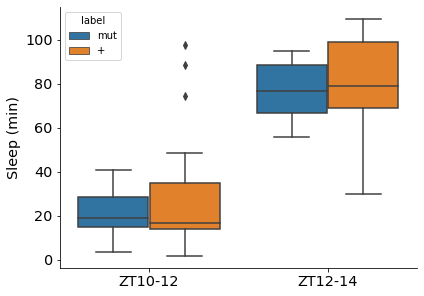

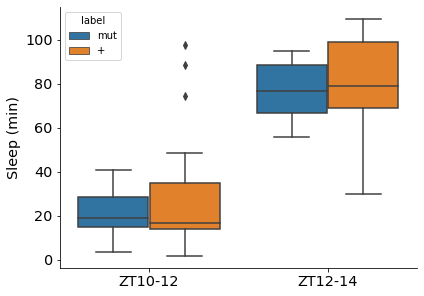

In [136]:
cumulative_sleep_fig([[mutant_zg_df], [control_zg_df]], ['mut', '+'], start_time=timedelta(hours=10), end_time=timedelta(hours=14), x_labels=['ZT10-12', 'ZT12-14'])

AssertionError: 

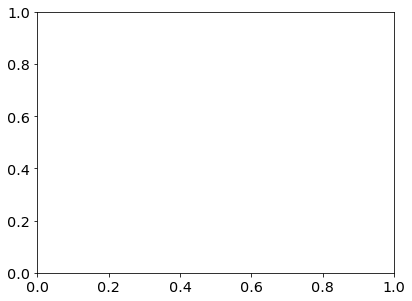

In [137]:
cumulative_sleep_fig([[mutant_zg_df], [control_zg_df]], ['mut', '+'], start_time=timedelta(hours=22), end_time=timedelta(hours=2), x_labels=['ZT10-12', 'ZT12-14'])

In [139]:
import pandas as pd

In [140]:
idx = pd.IndexSlice

In [145]:
mutant_zg_df.loc(axis=0)[idx[0:5, timedelta(hours=2):timedelta(hours=3)]]

light  fly_0  fly_1  fly_3  fly_6  fly_8  fly_10  fly_11  fly_14  fly_15  fly_20  fly_21  fly_22  \
day zg_time                                                                                                             
0   0 days 02:00:00      1      1      2      0      0      0       1       0       0       0       2       0       0   
    0 days 02:01:00      1      1      1      1      0      0       2       0       2       0       1       0       0   
    0 days 02:02:00      1      0      0      0      0      2       1       0       0       0       1       0       0   
    0 days 02:03:00      1      0      0      0      0      1       1       0       0       0       0       0       0   
    0 days 02:04:00      1      0      0      0      0      0       0       0       0       0       0       0       0   
...                    ...    ...    ...    ...    ...    ...     ...     ...     ...     ...     ...     ...     ...   
5   0 days 02:56:00      1      1      0      1      2      0       0       0       0       2       0       0       0   
    0 days 02:57:00      1      1      0      1      2      0       0       1       0       2       0       0       0   
    0 days 02:58:00      1      1      1      1      2      0       0       1       2       1       0       0       1   
    0 days 02:59:00      1      0      0      0      0      0       0       0       1       0       0       0       1   
    0 days 03:00:00      1      0      0      0      0      0       0       0       0       0       0       0       0   

                     fly_28  fly_29  fly_30  fly_31  
day zg_time                                          
0   0 days 02:00:00      11       0       1       1  
    0 days 02:01:00       4       0       1       0  
    0 days 02:02:00       0       0       0       1  
    0 days 02:03:00       0       0       0       0  
    0 days 02:04:00       0       0       5       0  
...                     ...     ...     ...     ...  
5   0 days 02:56:00       0       0       0       0  
    0 days 02:57:00       0       0       0       0  
    0 days 02:58:00       0       2       0       0  
    0 days 02:59:00       0       0       0       0  
    0 days 03:00:00       0       0       0       0  

[366 rows x 17 columns]

In [146]:
from sleep_analysis.analysis import group_by_light 

In [149]:
light_df = group_by_light([[mutant_zg_df], [control_zg_df]], ['mut', '+'], 'sleep', start_time=timedelta(hours=0), end_time=timedelta(hours=2))

In [150]:
dark_df = group_by_light([[mutant_zg_df], [control_zg_df]], ['mut', '+'], 'sleep', start_time=timedelta(hours=22), end_time=timedelta(hours=0))

In [151]:
pd.concat([light_df, dark_df]) 

light      sleep label
0   light  52.975207   mut
1   light  33.553719   mut
2   light  22.809917   mut
3   light  13.223140   mut
4   light  46.033058   mut
..    ...        ...   ...
34   dark  25.100764     +
35   dark  99.485754     +
36   dark  88.144545     +
37   dark  94.815844     +
38   dark  93.148019     +

[78 rows x 3 columns]

In [154]:
(timedelta(hours=22) - timedelta(hours=24)) < timedelta(hours=0) <  timedelta(hours=2)

True